In [1]:
#
# ------------------
# --- I. SETUP ---
# ------------------
#
# Make sure you have these libraries installed:
# pip install pandas seaborn matplotlib
#
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import re
import json

# --- Configuration ---
# Set the base directory where your results folders are located
BASE_RESULTS_DIR = Path('/clwork/kexin/tsar_st/results')

print(f"Searching for results in: {BASE_RESULTS_DIR}")

Searching for results in: /clwork/kexin/tsar_st/results


In [2]:
#
# --------------------------------
# --- II. DATA LOADING & MERGE (Skips 'cot' folders) ---
# --------------------------------
#
# This version skips any directory that has "cot" in its name.
#

all_scores = []
all_simplifications = []

print(f"Searching for results in: {BASE_RESULTS_DIR}")

for result_dir in BASE_RESULTS_DIR.iterdir():
    if not result_dir.is_dir():
        continue
    
    # ADDED THIS LINE TO SKIP 'cot' FOLDERS
    if 'cot' in result_dir.name:
        print(f"Skipping CoT folder: {result_dir.name}")
        continue
    # if 'claude' not in result_dir.name:
    #     continue

    dir_name = result_dir.name
    parts = dir_name.split('_')
    
    try:
        # Find the timestamp part (e.g., '250727-151039' or '20250727-164212')
        date_part_index = -1
        for i, part in enumerate(parts):
            if re.match(r'\d{6,8}-\d{6}', part):
                date_part_index = i
                break
        
        if date_part_index == -1:
            raise ValueError("No timestamp found in folder name")

        # Check if the folder name indicates a few-shot run
        if date_part_index > 2 and parts[date_part_index - 1] == 'shot':
            shots = int(parts[date_part_index - 2])
            model = parts[0]
            prompt_type = '_'.join(parts[1:date_part_index - 2])
        else:
            shots = 0
            model = parts[0]
            prompt_type = '_'.join(parts[1:date_part_index])

        setup_id = f"{model}_{prompt_type}_{shots}-shot" 

        # 1. Load individual scores
        scores_file = result_dir / 'individual_scores.jsonl'
        if scores_file.exists():
            with open(scores_file, 'r') as f:
                for line in f:
                    data = json.loads(line)
                    data['model'] = model
                    data['prompt_type'] = prompt_type
                    data['shots'] = shots
                    data['setup_id'] = setup_id
                    all_scores.append(data)

        # 2. Load simplifications
        simplifications_file = result_dir / 'simplifications.jsonl'
        if simplifications_file.exists():
            with open(simplifications_file, 'r') as f:
                for line in f:
                    data = json.loads(line)
                    data['model'] = model
                    data['prompt_type'] = prompt_type
                    data['shots'] = shots
                    data['setup_id'] = setup_id
                    all_simplifications.append(data)

    except (ValueError, IndexError):
        print(f"Skipping folder (name format mismatch): {dir_name}")
        continue

# Create and merge DataFrames
if not all_scores or not all_simplifications:
    print("\nError: No data was loaded. Please check your BASE_RESULTS_DIR and folder names.")
else:
    scores_df = pd.DataFrame(all_scores)
    simplifications_df = pd.DataFrame(all_simplifications)
    df = pd.merge(
        scores_df,
        simplifications_df[['text_id', 'setup_id', 'simplified', 'full_prompt']],
        on=['text_id', 'setup_id']
    )

    print("\nData loading complete!")
    print(f"Loaded a total of {len(df)} entries from {len(df['setup_id'].unique())} setups.")
    print("\nMaster DataFrame columns:")
    print(df.info())
    print("\nFirst 5 rows of the master DataFrame:")
    display(df.head())

Searching for results in: /clwork/kexin/tsar_st/results
Skipping CoT folder: gpt4o_cot_20250727-173349
Skipping folder (name format mismatch): a.compiled_results

Data loading complete!
Loaded a total of 1800 entries from 45 setups.

Master DataFrame columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   text_id                    1800 non-null   object 
 1   target_cefr                1800 non-null   object 
 2   predicted_cefr             1800 non-null   object 
 3   cefr_adj_accuracy          1800 non-null   int64  
 4   meaningbert_orig           1800 non-null   float64
 5   bertscore_f1_orig          1800 non-null   float64
 6   meaningbert_ref            1800 non-null   float64
 7   bertscore_f1_ref           1800 non-null   float64
 8   predicted_cefr_confidence  1800 non-null   float64
 9   cefr_probas 

text_id target_cefr predicted_cefr  cefr_adj_accuracy  meaningbert_orig  \
0   01-a2          A2             A2                  1            0.7641   
1   01-b1          B1             B2                  1            0.8374   
2   02-a2          A2             A2                  1            0.6584   
3   02-b1          B1             B1                  1            0.8578   
4   03-a2          A2             B1                  1            0.8438   

   bertscore_f1_orig  meaningbert_ref  bertscore_f1_ref  \
0             0.9431           0.8410            0.9266   
1             0.9531           0.8480            0.9185   
2             0.9314           0.7825            0.9199   
3             0.9526           0.9453            0.9553   
4             0.9571           0.6548            0.9040   

   predicted_cefr_confidence  \
0                     0.9981   
1                     1.0000   
2                     0.9986   
3                     0.9961   
4                     1.0000   

                                         cefr_probas  model       prompt_type  \
0  {'ModernBERT-base-doc_en-Cefr': {'A1': 3.2e-05...  gpt4o  with_description   
1  {'ModernBERT-base-doc_en-Cefr': {'A1': 3.3e-05...  gpt4o  with_description   
2  {'ModernBERT-base-doc_en-Cefr': {'A1': 0.00012...  gpt4o  with_description   
3  {'ModernBERT-base-doc_en-Cefr': {'A1': 0.00016...  gpt4o  with_description   
4  {'ModernBERT-base-doc_en-Cefr': {'A1': 9e-06, ...  gpt4o  with_description   

   shots                       setup_id  \
0      2  gpt4o_with_description_2-shot   
1      2  gpt4o_with_description_2-shot   
2      2  gpt4o_with_description_2-shot   
3      2  gpt4o_with_description_2-shot   
4      2  gpt4o_with_description_2-shot   

                                          simplified  \
0  NASA is now trying to find smaller asteroids. ...   
1  NASA is now trying to record some of the small...   
2  Earthquakes can break things, like bridges. Lu...   
3  Earthquakes can damage all buildings, includin...   
4  The Hunger Games happen every year. The Capito...   

                                         full_prompt  
0  Please simplify the following Complex Document...  
1  Please simplify the following Complex Document...  
2  Please simplify the following Complex Document...  
3  Please simplify the following Complex Document...  
4  Please simplify the following Complex Document...

In [3]:
try:
    # Load the original complex documents
    with open('/clwork/kexin/tsar_st/data/input/documents.jsonl', 'r') as f:
        original_data = [json.loads(line) for line in f]
    original_df = pd.DataFrame(original_data)
    # Rename the 'original' column to 'original_text' for clarity
    original_df = original_df.rename(columns={'original': 'original_text'})

    # Load the human reference simplifications
    with open('/clwork/kexin/tsar_st/data/references/human_simplifications.jsonl', 'r') as f:
        references_data = [json.loads(line) for line in f]
    ref_df = pd.DataFrame(references_data)
    # Rename the 'reference' column to 'reference_text'
    ref_df = ref_df.rename(columns={'reference': 'reference_text'})
    
    # --- 3. Create the Base for the Final DataFrame ---
    # Merge original and reference texts on 'text_id'
    # This will be our base, with one row per unique text item.
    final_df_base = pd.merge(
        original_df[['text_id', 'original_text']], 
        ref_df[['text_id', 'reference_text']], 
        on='text_id',
        how='left'
    ).set_index('text_id')

except FileNotFoundError as e:
    print(f"Error: Could not find a source file. {e}")
    # Stop execution if files are missing
    raise

# --- 4. Pivot the System-Specific Data ---
# Select only the columns that vary by system setup
cols_to_pivot = [
    'simplified',
    'predicted_cefr',
    'meaningbert_orig',
    'bertscore_f1_orig',
    'meaningbert_ref',
    'bertscore_f1_ref'
]

# Pivot the main dataframe to get system outputs in wide format
pivoted_df = df.pivot(
    index='text_id',
    columns='setup_id',
    values=cols_to_pivot
)

# Flatten the multi-level column names
pivoted_df.columns = [f"{col_level_1}_{col_level_2}" for col_level_1, col_level_2 in pivoted_df.columns]

# --- 5. Combine Base and Pivoted Data ---
# Join the base (original/reference) with the pivoted system data
final_df = final_df_base.join(pivoted_df)

print("Pivoted DataFrame created successfully!")
display(final_df.head())
print("\nColumns in the final DataFrame:")
print(final_df.columns)

Pivoted DataFrame created successfully!


original_text  \
text_id                                                      
01-a2    Now NASA is working towards logging some of th...   
01-b1    Now NASA is working towards logging some of th...   
02-a2    Earthquakes damage all structures, including b...   
02-b1    Earthquakes damage all structures, including b...   
03-a2    The Hunger Games are an annual event, which th...   

                                            reference_text  \
text_id                                                      
01-a2    Asteroids are small rocks in space. NASA is co...   
01-b1    Asteroids are rocks that fly through space. NA...   
02-a2    An earthquake means when the ground shakes a l...   
02-b1    Earthquakes damage all kinds of buildings, inc...   
03-a2    The 'Hunger Games' happen every year. Why? To ...   

               simplified_claude4_1_shot_confidence_0-shot  \
text_id                                                      
01-a2    NASA is trying to find and count smaller aster...   
01-b1    Now NASA is working to find and record some of...   
02-a2    Earthquakes can break buildings and bridges. B...   
02-b1    Earthquakes damage all buildings, including br...   
03-a2    The Hunger Games happen every year. The Capito...   

        simplified_claude4_1_shot_contrastive_confidence_0-shot  \
text_id                                                           
01-a2    NASA is a space organization. They are trying ...        
01-b1    Now NASA is working to record information abou...        
02-a2    Earthquakes are when the ground moves very str...        
02-b1    Earthquakes damage all buildings and structure...        
03-a2    The Hunger Games happen every year. The Capito...        

                    simplified_claude_4_contrastive_0-shot  \
text_id                                                      
01-a2    Now NASA is making a list of smaller space roc...   
01-b1    Now NASA is working to record some of the smal...   
02-a2    Earthquakes can break bridges and other buildi...   
02-b1    Earthquakes cause damage to all buildings and ...   
03-a2    The Hunger Games happen every year. The Capito...   

                         simplified_claude_4_target_0-shot  \
text_id                                                      
01-a2    Now NASA is trying to find and record smaller ...   
01-b1    NASA is now trying to find and record smaller ...   
02-a2    Earthquakes can break all buildings, including...   
02-b1    Earthquakes can damage all buildings, includin...   
03-a2    The Hunger Games happen every year. The Capito...   

               simplified_claude_4_with_description_0-shot  \
text_id                                                      
01-a2    Now NASA is working to find and record smaller...   
01-b1    NASA is now trying to find and record smaller ...   
02-a2    Earthquakes can break all buildings, including...   
02-b1    Earthquakes can break all buildings, including...   
03-a2    The Hunger Games happen every year. The Capito...   

               simplified_claude_4_with_description_1-shot  \
text_id                                                      
01-a2    Now NASA is working to find and record smaller...   
01-b1    Now NASA is working to find and record some of...   
02-a2    Earthquakes can break bridges and other buildi...   
02-b1    Earthquakes damage all buildings, including br...   
03-a2    Every year, there is something called the Hung...   

               simplified_claude_4_with_description_2-shot  \
text_id                                                      
01-a2    NASA is now trying to find smaller asteroids. ...   
01-b1    Now NASA is working to find and record some of...   
02-a2    Earthquakes can break all buildings, including...   
02-b1    Earthquakes damage all buildings and structure...   
03-a2    The Hunger Games happen every year. The Capito...   

                simplified_gemma3_1_shot_confidence_0-shot  ...  \
text_id                     


Columns in the final DataFrame:
Index(['original_text', 'reference_text',
       'simplified_claude4_1_shot_confidence_0-shot',
       'simplified_claude4_1_shot_contrastive_confidence_0-shot',
       'simplified_claude_4_contrastive_0-shot',
       'simplified_claude_4_target_0-shot',
       'simplified_claude_4_with_description_0-shot',
       'simplified_claude_4_with_description_1-shot',
       'simplified_claude_4_with_description_2-shot',
       'simplified_gemma3_1_shot_confidence_0-shot',
       ...
       'bertscore_f1_ref_o1_with_description_1-shot',
       'bertscore_f1_ref_o1_with_description_2-shot',
       'bertscore_f1_ref_o3_1_shot_confidence_0-shot',
       'bertscore_f1_ref_o3_1_shot_contrastive_confidence_0-shot',
       'bertscore_f1_ref_o3_2_shot_confidence_0-shot',
       'bertscore_f1_ref_o3_contrastive_0-shot',
       'bertscore_f1_ref_o3_target_0-shot',
       'bertscore_f1_ref_o3_with_description_0-shot',
       'bertscore_f1_ref_o3_with_description_1-shot',


In [4]:
import pandas as pd
import spacy
import textstat
from wordfreq import word_frequency
import numpy as np

# --- 1. Setup ---
nlp = spacy.load('en_core_web_sm')

# --- 2. Define Individual Feature Functions ---
# (No changes needed in these individual functions)
def get_avg_word_frequency(doc):
    """Calculates average word frequency using the 'wordfreq' library."""
    total_freq = sum(word_frequency(token.text, 'en') for token in doc if token.is_alpha)
    num_tokens = len([token for token in doc if token.is_alpha])
    return total_freq / num_tokens if num_tokens > 0 else 0

def get_type_token_ratio(doc):
    """Calculates Type-Token Ratio (TTR) based on lemmas."""
    lemmas = {token.lemma_ for token in doc if token.is_alpha}
    num_tokens = len([token for token in doc if token.is_alpha])
    return len(lemmas) / num_tokens if num_tokens > 0 else 0

def get_passive_voice_ratio(doc):
    """Calculates the ratio of sentences containing a passive verb."""
    passive_sents = 0
    for sent in doc.sents:
        if any(token.dep_ in ['nsubjpass', 'auxpass'] for token in sent):
            passive_sents += 1
    num_sents = len(list(doc.sents))
    return passive_sents / num_sents if num_sents > 0 else 0

def get_avg_dependency_distance(doc):
    """Calculates the average syntactic dependency distance."""
    distances = [abs(token.i - token.head.i) for token in doc]
    return np.mean(distances) if distances else 0

# --- 3. Create the Main Orchestrator Function ---
def calculate_all_features(text):
    """A single function to calculate all linguistic features for a given text."""
    if not isinstance(text, str) or not text:
        return {feat: np.nan for feat in FEATURE_LIST}

    doc = nlp(text)
    
    # Pre-calculate counts for efficiency
    word_count = len([token for token in doc if token.is_alpha])
    sent_count = len(list(doc.sents))

    features = {
        'avg_word_freq': get_avg_word_frequency(doc),
        'ttr': get_type_token_ratio(doc),
        'passive_ratio': get_passive_voice_ratio(doc),
        'avg_dep_dist': get_avg_dependency_distance(doc),
        'avg_sent_len': word_count / sent_count if sent_count > 0 else 0,
        'lexical_density': len([t for t in doc if t.pos_ in ['NOUN', 'VERB', 'ADJ', 'ADV']]) / word_count if word_count > 0 else 0,
        'readability': textstat.flesch_kincaid_grade(text),
        # --- ADDED NEW FEATURES HERE ---
        'word_count': word_count,
        'sent_count': sent_count
    }
    
    return features

# --- 4. Apply the Modular Function to Your DataFrame ---

# --- ADDED NEW FEATURES TO THE LIST ---
FEATURE_LIST = [
    'readability', 'avg_sent_len', 'lexical_density',
    'avg_word_freq', 'ttr', 'passive_ratio', 'avg_dep_dist',
    'word_count', 'sent_count'
]

features_df = pd.DataFrame(index=final_df.index)
text_columns = ['original_text', 'reference_text'] + [col for col in final_df.columns if 'simplified' in col]

for col in text_columns:
    feature_results = final_df[col].apply(calculate_all_features).apply(pd.Series)
    features_df[[f'{feat}_{col}' for feat in feature_results.columns]] = feature_results

print("All linguistic features calculated successfully using the modular structure!")
display(features_df.head())

/tmp/ipykernel_12556/1907049350.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_df[[f'{feat}_{col}' for feat in feature_results.columns]] = feature_results
/tmp/ipykernel_12556/1907049350.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_df[[f'{feat}_{col}' for feat in feature_results.columns]] = feature_results
/tmp/ipykernel_12556/1907049350.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider

All linguistic features calculated successfully using the modular structure!


/tmp/ipykernel_12556/1907049350.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_df[[f'{feat}_{col}' for feat in feature_results.columns]] = feature_results
/tmp/ipykernel_12556/1907049350.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_df[[f'{feat}_{col}' for feat in feature_results.columns]] = feature_results
/tmp/ipykernel_12556/1907049350.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider

avg_word_freq_original_text  ttr_original_text  \
text_id                                                   
01-a2                       0.006802           0.765625   
01-b1                       0.006802           0.765625   
02-a2                       0.004447           0.861111   
02-b1                       0.004447           0.861111   
03-a2                       0.009197           0.701493   

         passive_ratio_original_text  avg_dep_dist_original_text  \
text_id                                                            
01-a2                       0.333333                    3.419753   
01-b1                       0.333333                    3.419753   
02-a2                       0.000000                    2.309524   
02-b1                       0.000000                    2.309524   
03-a2                       1.000000                    2.473684   

         avg_sent_len_original_text  lexical_density_original_text  \
text_id                                                              
01-a2                     21.333333                       0.484375   
01-b1                     21.333333                       0.484375   
02-a2                     12.000000                       0.666667   
02-b1                     12.000000                       0.666667   
03-a2                     16.750000                       0.432836   

         readability_original_text  word_count_original_text  \
text_id                                                        
01-a2                    12.704638                      64.0   
01-b1                    12.704638                      64.0   
02-a2                    10.067778                      36.0   
02-b1                    10.067778                      36.0   
03-a2                     8.580978                      67.0   

         sent_count_original_text  avg_word_freq_reference_text  ...  \
text_id                                                          ...   
01-a2                         3.0                      0.005797  ...   
01-b1                         3.0                      0.006902  ...   
02-a2                         3.0                      0.004311  ...   
02-b1                         3.0                      0.003165  ...   
03-a2                         4.0                      0.011156  ...   

         sent_count_simplified_o3_with_description_1-shot  \
text_id                                                     
01-a2                                                 6.0   
01-b1                                                 5.0   
02-a2                                                 3.0   
02-b1                                                 3.0   
03-a2                                                 7.0   

         avg_word_freq_simplified_o3_with_description_2-shot  \
text_id                                                        
01-a2                                             0.005226     
01-b1                                             0.005538     
02-a2                                             0.003126     
02-b1                                             0.002294     
03-a2                                             0.009708     

         ttr_simplified_o3_with_description_2-shot  \
text_id                                              
01-a2                                     0.724638   
01-b1                                     0.746269   
02-a2                                     0.884615   
02-b1                                     0.852941   
03-a2                                     0.666667   

         passive_ratio_simplified_o3_with_description_2-shot  \
text_id                                                        
01-a2                                             0.142857     
01-b1                                             0.000000     
02-a2                                             0.000000     
02-b1                                             0.000000     
03-a2                            

In [5]:
# Assume 'features_df' is the DataFrame you created with all the linguistic features.
# Assume 'FEATURE_LIST' contains the names of your features.

delta_df = pd.DataFrame(index=features_df.index)

# Loop through each feature name (e.g., 'readability', 'avg_sent_len')
for feature in FEATURE_LIST:
    # Get the feature values for the original text as a Series
    original_series = features_df.get(f'{feature}_original_text')

    # If the original text feature doesn't exist for some reason, skip to the next feature
    if original_series is None:
        print(f"Warning: Could not find original feature column for '{feature}'")
        continue

    # --- Calculate Deltas for Automated Systems ---
    # Find all columns that correspond to a simplified system's output for this feature
    simplified_cols = [col for col in features_df.columns if col.startswith(f'{feature}_simplified_')]
    
    for simp_col in simplified_cols:
        # Extract the system name directly from the column name
        system_name = simp_col.replace(f'{feature}_simplified_', '')
        # Calculate the delta and add it to the DataFrame
        # delta_df[f'{feature}_delta_{system_name}'] = original_series - features_df[simp_col]
        delta_df[f'{feature}_delta_{system_name}'] = features_df[simp_col] - original_series

    # --- Calculate Delta for the Human Reference ---
    reference_col = f'{feature}_reference_text'
    if reference_col in features_df:
        delta_df[f'{feature}_delta_human_reference'] = features_df[reference_col] - original_series

print("Delta DataFrame created successfully!")
# Display the first few rows to confirm it's populated
display(delta_df.head())

Delta DataFrame created successfully!


/tmp/ipykernel_12556/1175267546.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  delta_df[f'{feature}_delta_{system_name}'] = features_df[simp_col] - original_series
/tmp/ipykernel_12556/1175267546.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  delta_df[f'{feature}_delta_{system_name}'] = features_df[simp_col] - original_series
/tmp/ipykernel_12556/1175267546.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider

readability_delta_claude4_1_shot_confidence_0-shot  \
text_id                                                       
01-a2                                            -7.570471    
01-b1                                            -5.833167    
02-a2                                            -4.750278    
02-b1                                             0.200871    
03-a2                                            -4.567407    

         readability_delta_claude4_1_shot_contrastive_confidence_0-shot  \
text_id                                                                   
01-a2                                            -8.685398                
01-b1                                            -1.880125                
02-a2                                            -5.491414                
02-b1                                             0.782222                
03-a2                                            -4.860044                

         readability_delta_claude_4_contrastive_0-shot  \
text_id                                                  
01-a2                                        -9.529111   
01-b1                                        -1.274248   
02-a2                                        -4.679790   
02-b1                                         1.247407   
03-a2                                        -4.192342   

         readability_delta_claude_4_target_0-shot  \
text_id                                             
01-a2                                   -7.096471   
01-b1                                   -6.189596   
02-a2                                   -4.391985   
02-b1                                   -1.497778   
03-a2                                   -3.197529   

         readability_delta_claude_4_with_description_0-shot  \
text_id                                                       
01-a2                                            -6.545054    
01-b1                                            -6.402138    
02-a2                                            -4.647778    
02-b1                                            -5.008687    
03-a2                                            -3.195740    

         readability_delta_claude_4_with_description_1-shot  \
text_id                                                       
01-a2                                            -6.903809    
01-b1                                            -5.827893    
02-a2                                            -4.104180    
02-b1                                            -1.825556    
03-a2                                            -4.406156    

         readability_delta_claude_4_with_description_2-shot  \
text_id                                                       
01-a2                                            -7.094702    
01-b1                                            -5.813274    
02-a2                                            -4.740505    
02-b1                                            -1.311111    
03-a2                                            -4.931868    

         readability_delta_gemma3_1_shot_confidence_0-shot  \
text_id                                                      
01-a2                                            -8.297044   
01-b1                                            -5.005814   
02-a2                                            -3.488990   
02-b1                                            -1.455425   
03-a2                                            -2.753281   

         readability_delta_gemma3_1_shot_contrastive_confidence_0-shot  \
text_id                                                                  
01-a2                                            -9.937763               
01-b1                                            -5.132427               
02-a2                                            -1.216349               
02-b1                                            -2.196070               
03-a2                                            -4.15472

/tmp/ipykernel_12556/3334927426.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=deltas.index, y=deltas.values, palette='viridis')


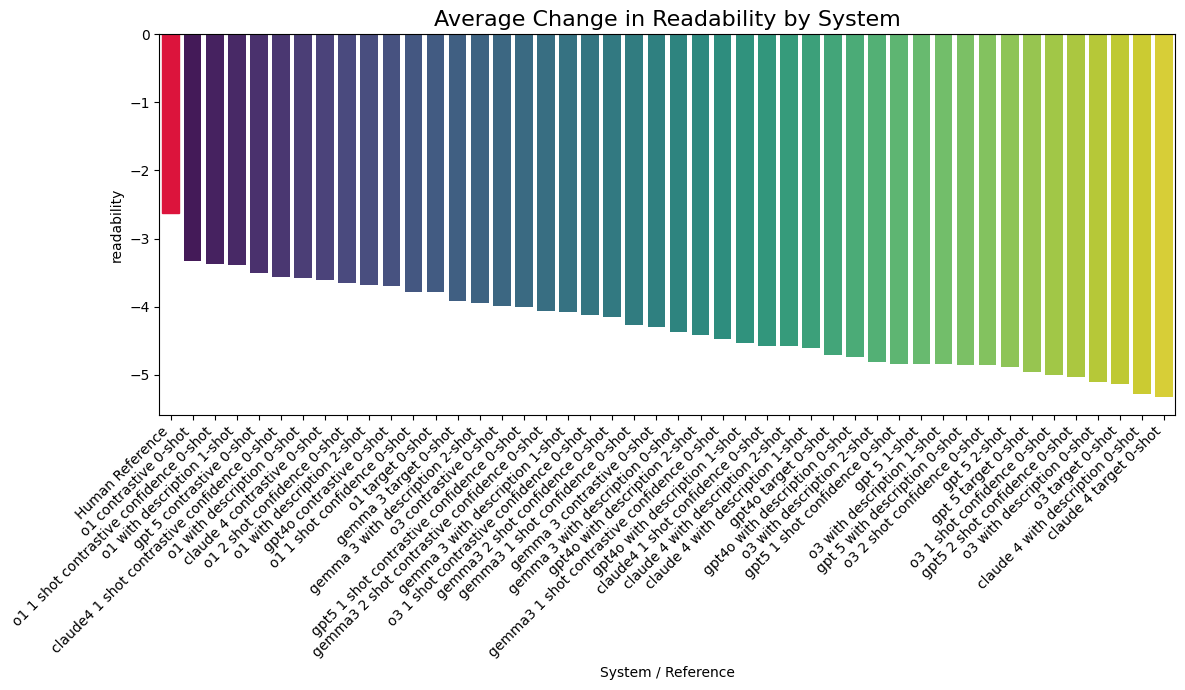

/tmp/ipykernel_12556/3334927426.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=deltas.index, y=deltas.values, palette='viridis')


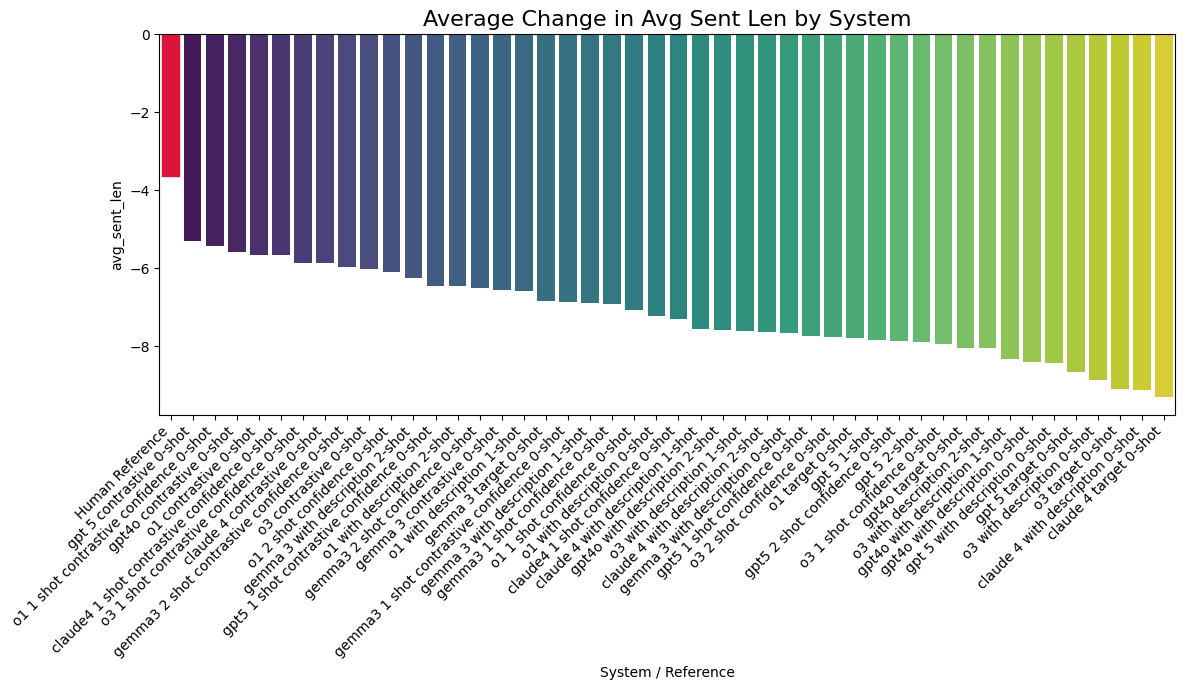

/tmp/ipykernel_12556/3334927426.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=deltas.index, y=deltas.values, palette='viridis')


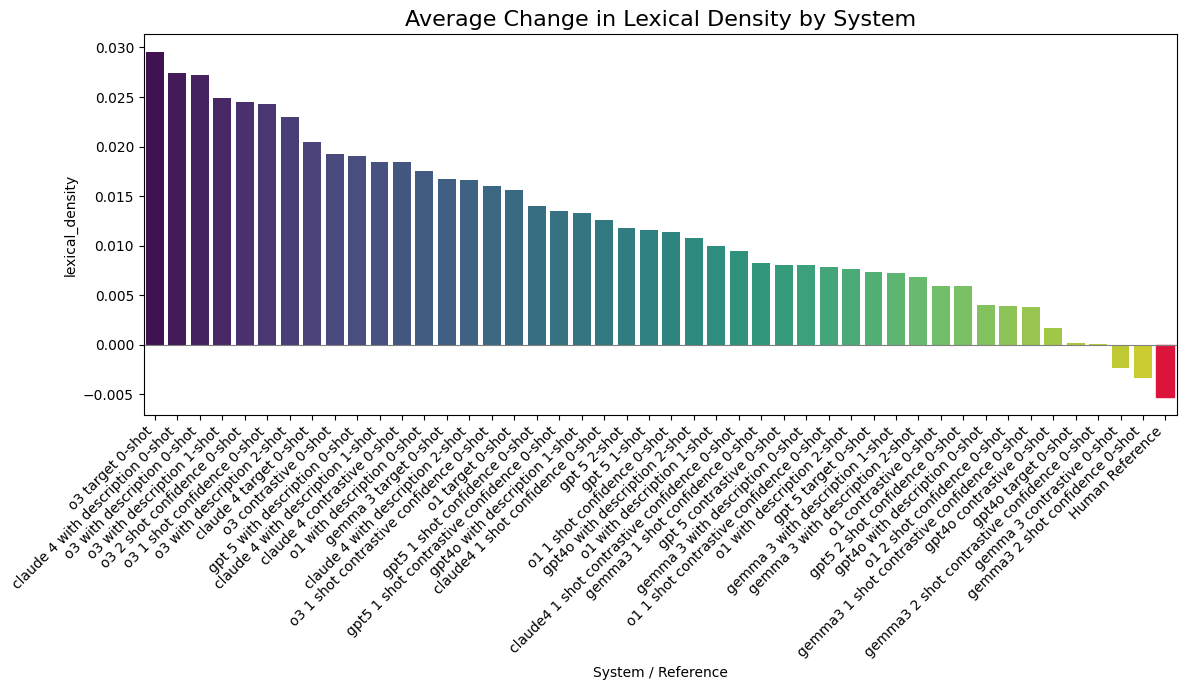

/tmp/ipykernel_12556/3334927426.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=deltas.index, y=deltas.values, palette='viridis')


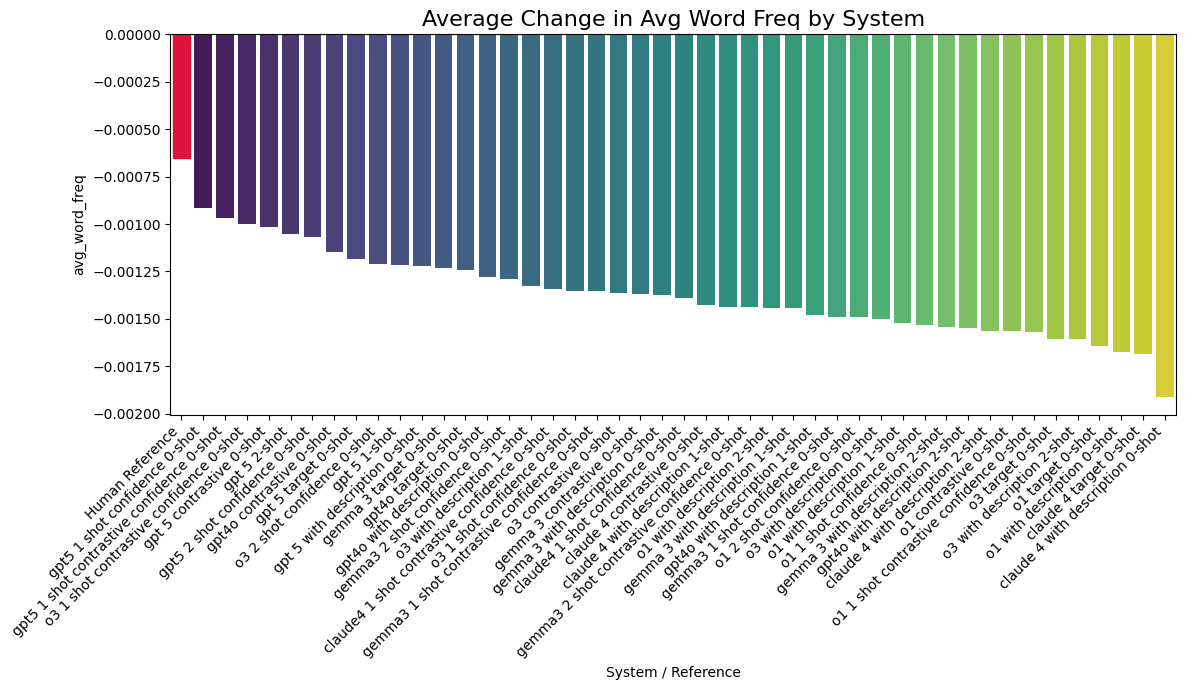

/tmp/ipykernel_12556/3334927426.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=deltas.index, y=deltas.values, palette='viridis')


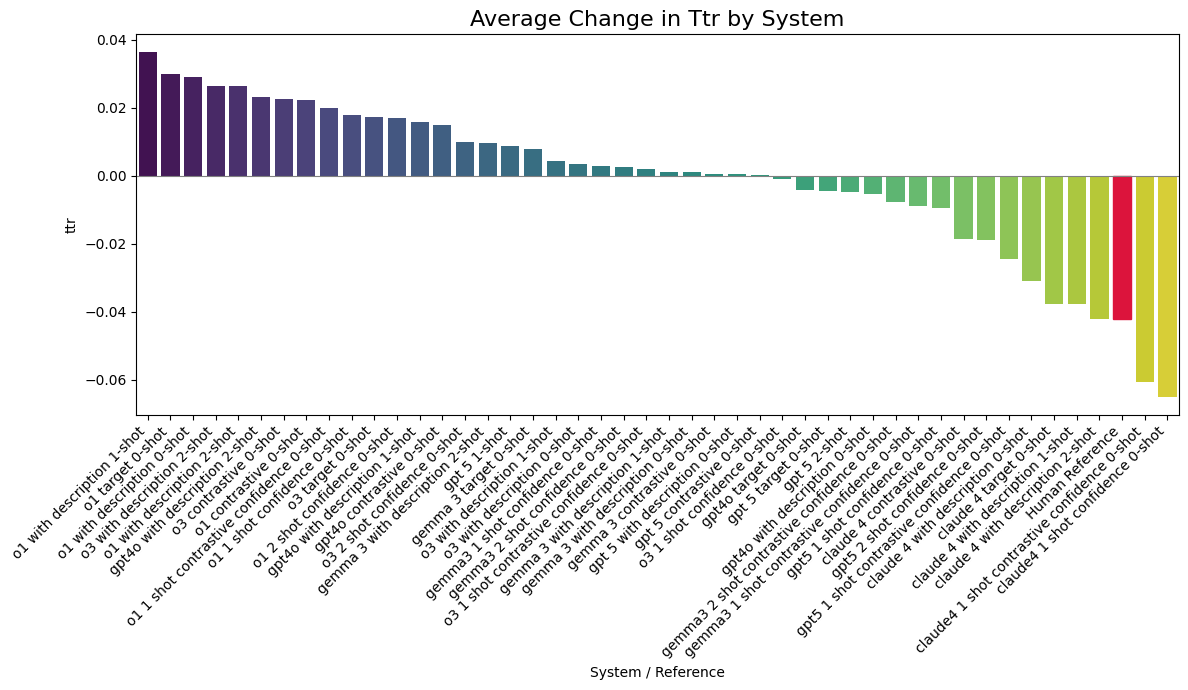

/tmp/ipykernel_12556/3334927426.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=deltas.index, y=deltas.values, palette='viridis')


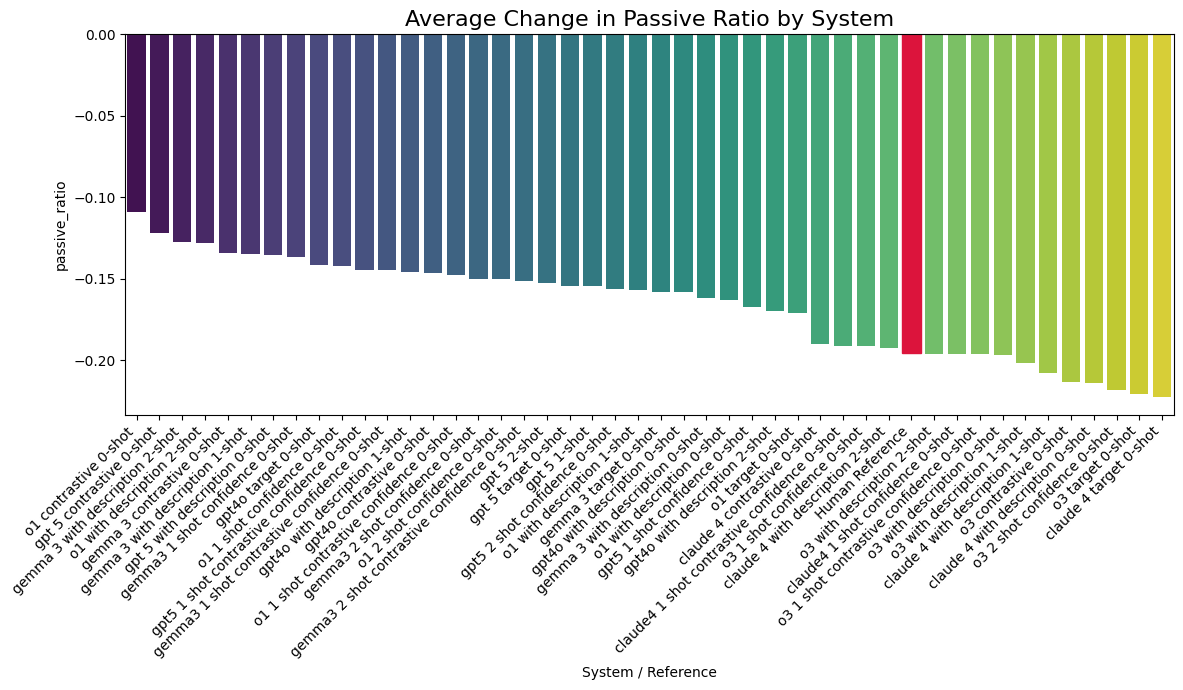

/tmp/ipykernel_12556/3334927426.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=deltas.index, y=deltas.values, palette='viridis')


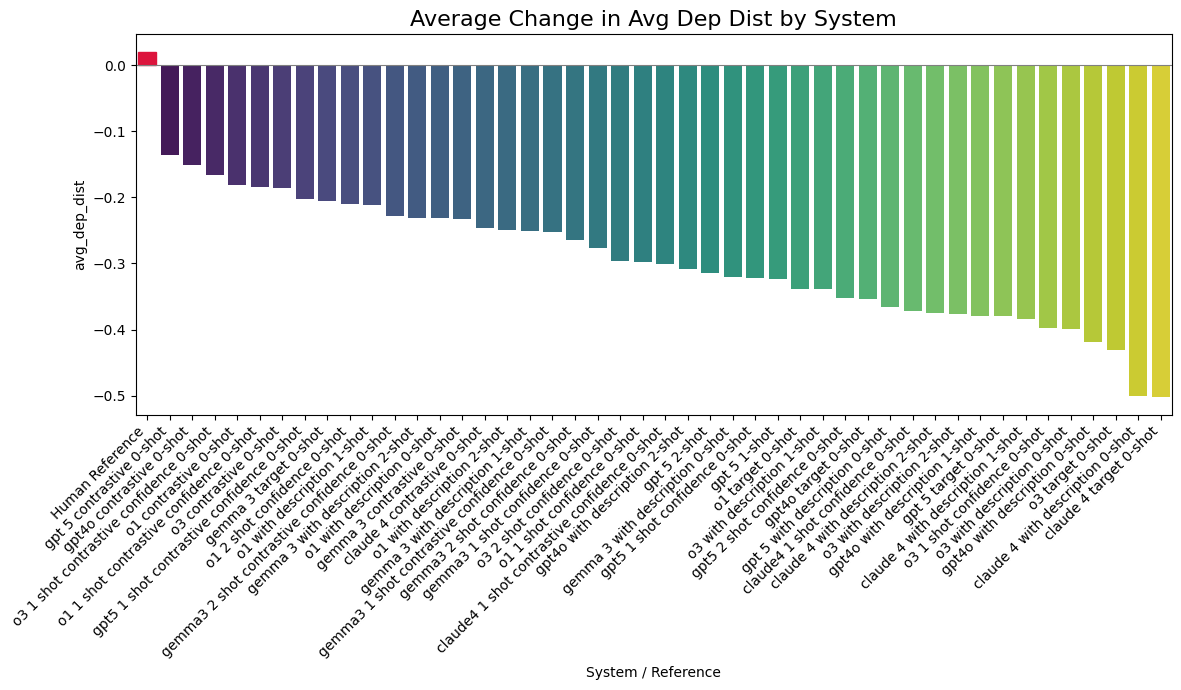

/tmp/ipykernel_12556/3334927426.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=deltas.index, y=deltas.values, palette='viridis')


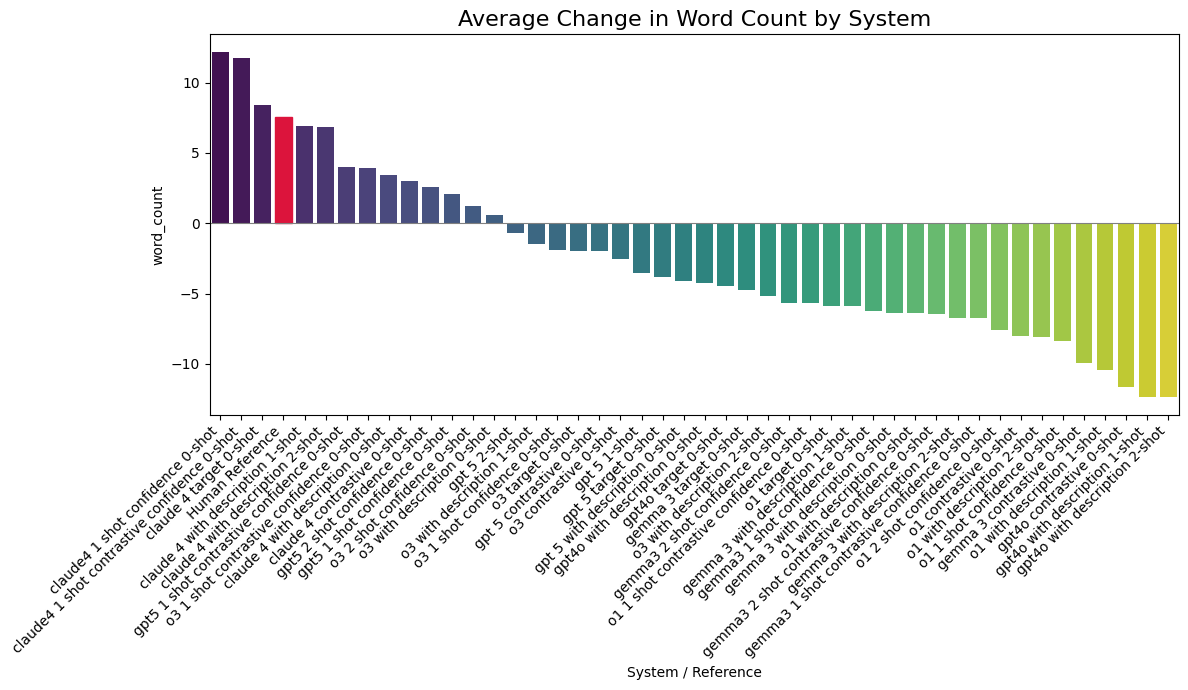

/tmp/ipykernel_12556/3334927426.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=deltas.index, y=deltas.values, palette='viridis')


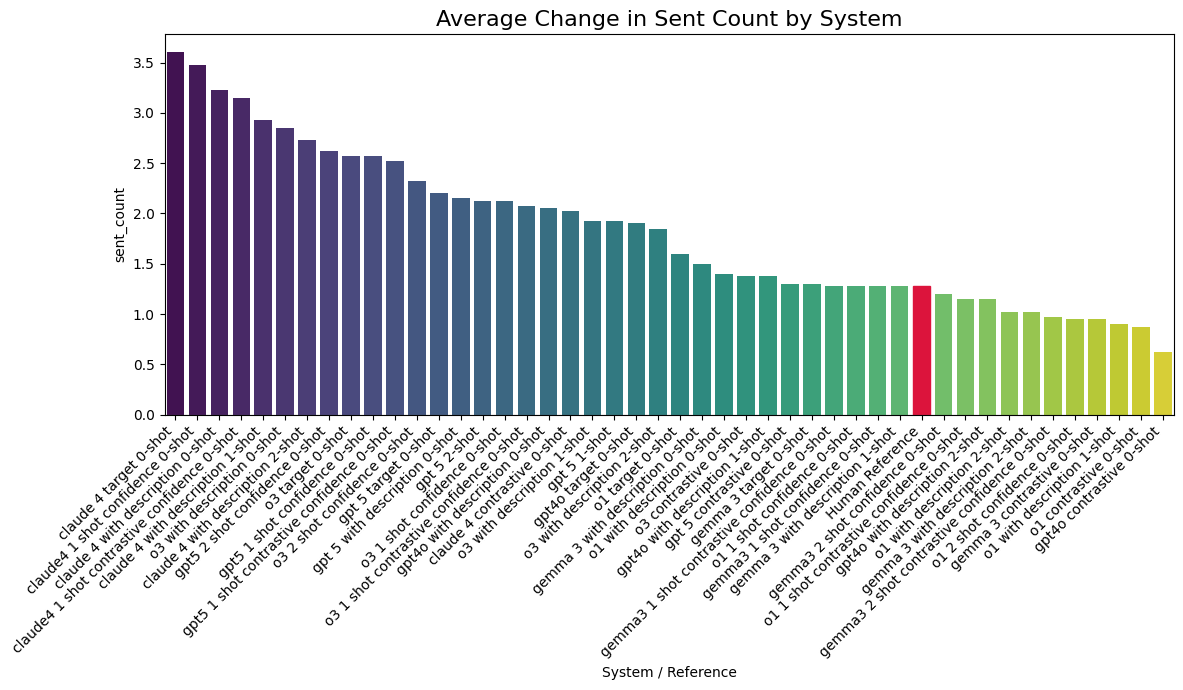

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Define more direct labels for all 7 features ---
feature_labels = {
    'readability': 'Change in Readability Score',
    'avg_sent_len': 'Change in Average Sentence Length',
    'lexical_density': 'Change in Lexical Density',
    'avg_word_freq': 'Change in Average Word Frequency',
    'ttr': 'Change in Type-Token Ratio',
    'passive_ratio': 'Change in Passive Voice Ratio',
    'avg_dep_dist': 'Change in Average Dependency Distance'
}

# --- Automated Bar Plots (Simplified Logic) ---
for feature in FEATURE_LIST:
    # # REMOVED THE IF/ELSE: Calculate the mean delta the same way for all features.
    deltas = delta_df.filter(like=f'{feature}_delta').mean().sort_values(ascending=False)
    
    deltas.index = [idx.replace(f'{feature}_delta_', '').replace('_', ' ').replace('human reference', 'Human Reference') for idx in deltas.index]

    plt.figure(figsize=(12, 7))
    barplot = sns.barplot(x=deltas.index, y=deltas.values, palette='viridis')
    
    # Add a horizontal line at y=0 for easy reference
    plt.axhline(0, color='grey', linewidth=0.8)
    
    # Highlight the bar for the human reference
    for bar in barplot.patches:
        if 'Human Reference' in barplot.get_xticklabels()[int(bar.get_x() + bar.get_width() / 2)].get_text():
            bar.set_color('crimson')
            
    plt.title(f'Average Change in {feature.replace("_", " ").title()} by System', fontsize=16)
    plt.ylabel(feature)
    plt.xlabel('System / Reference')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    # deltas = delta_df.filter(like=f'{feature}_delta').mean().sort_index()
    
    # deltas.index = [idx.replace(f'{feature}_delta_', '').replace('_', ' ').replace('human reference', 'Human Reference') for idx in deltas.index]

    # plt.figure(figsize=(12, 7))
    # barplot = sns.barplot(x=deltas.index, y=deltas.values, palette='viridis')
    
    # # Add a horizontal line at y=0 for easy reference
    # plt.axhline(0, color='grey', linewidth=0.8)
    
    # # Highlight the bar for the human reference
    # for bar in barplot.patches:
    #     current_label = barplot.get_xticklabels()[int(bar.get_x() + bar.get_width() / 2)].get_text()
    #     if 'Human Reference' in current_label:
    #         bar.set_color('crimson')
            
    # plt.title(f'Average Change in {feature.replace("_", " ").title()} by System', fontsize=16)
    # plt.ylabel(feature_labels.get(feature, feature)) # Using your labels dictionary
    # plt.xlabel('System / Reference')
    # plt.xticks(rotation=45, ha='right')
    # plt.tight_layout()
    # plt.show()

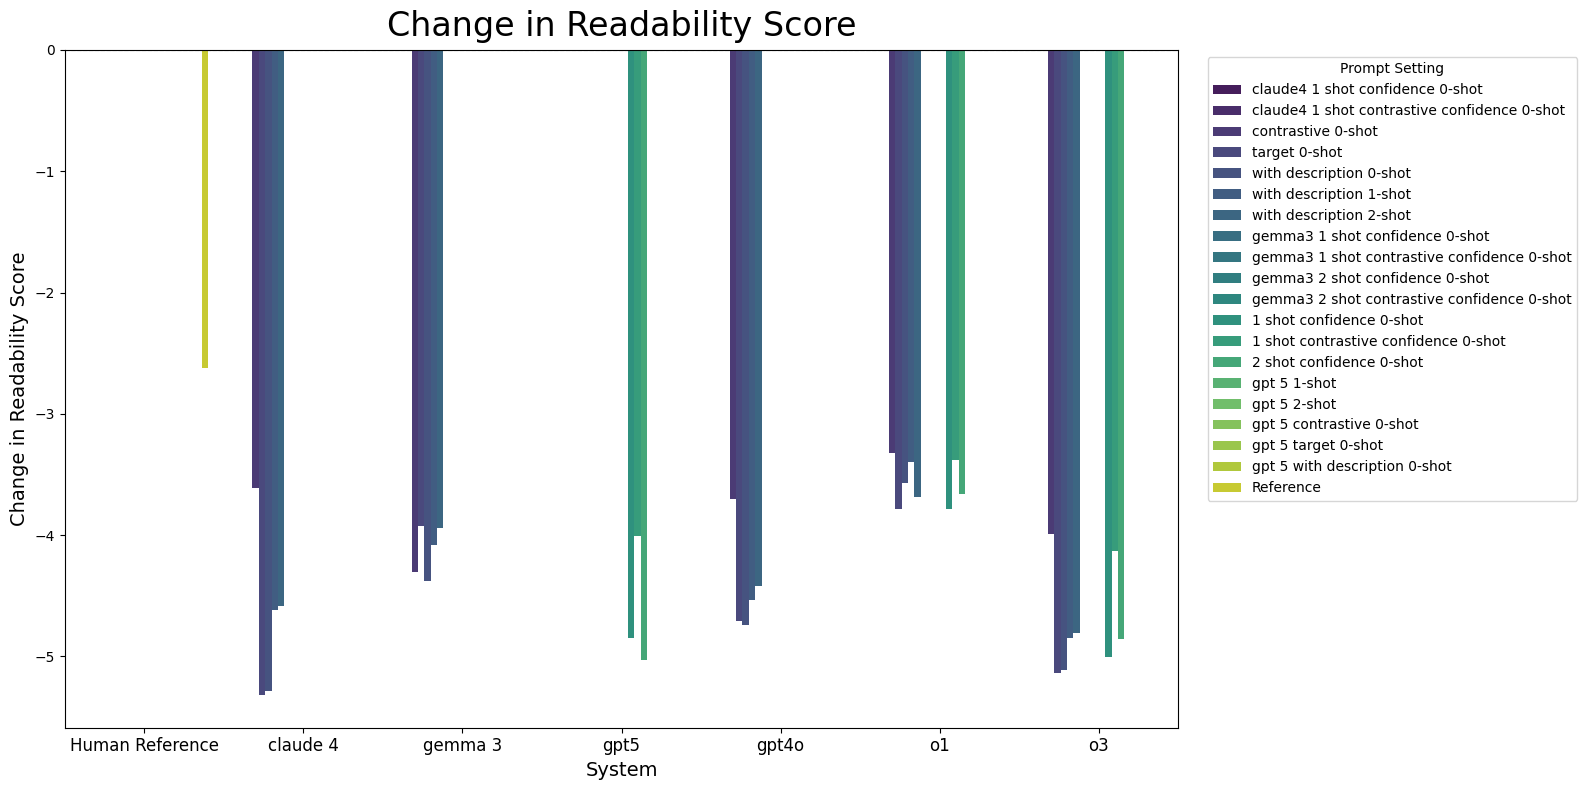

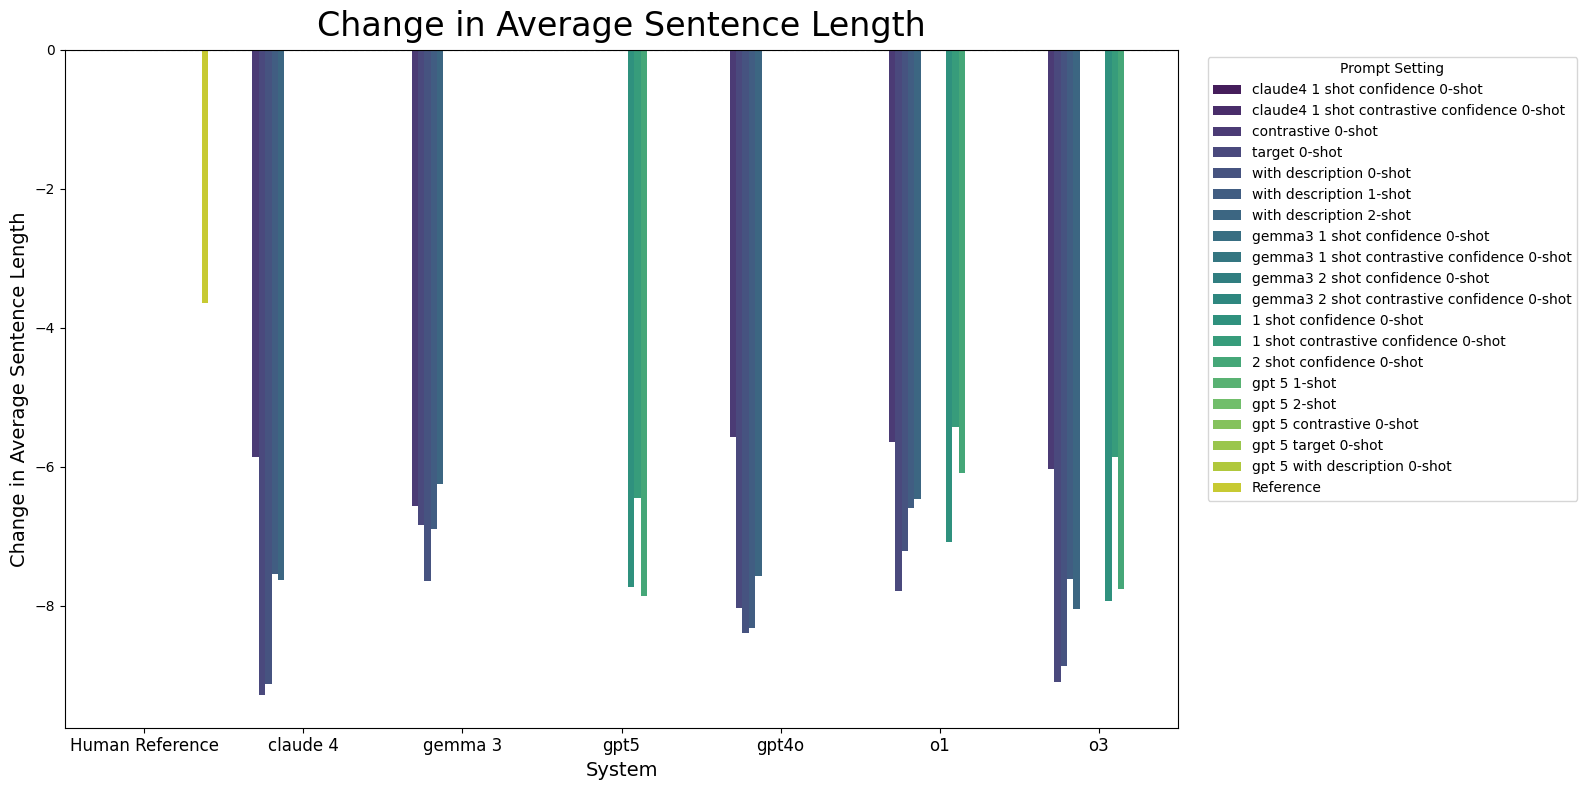

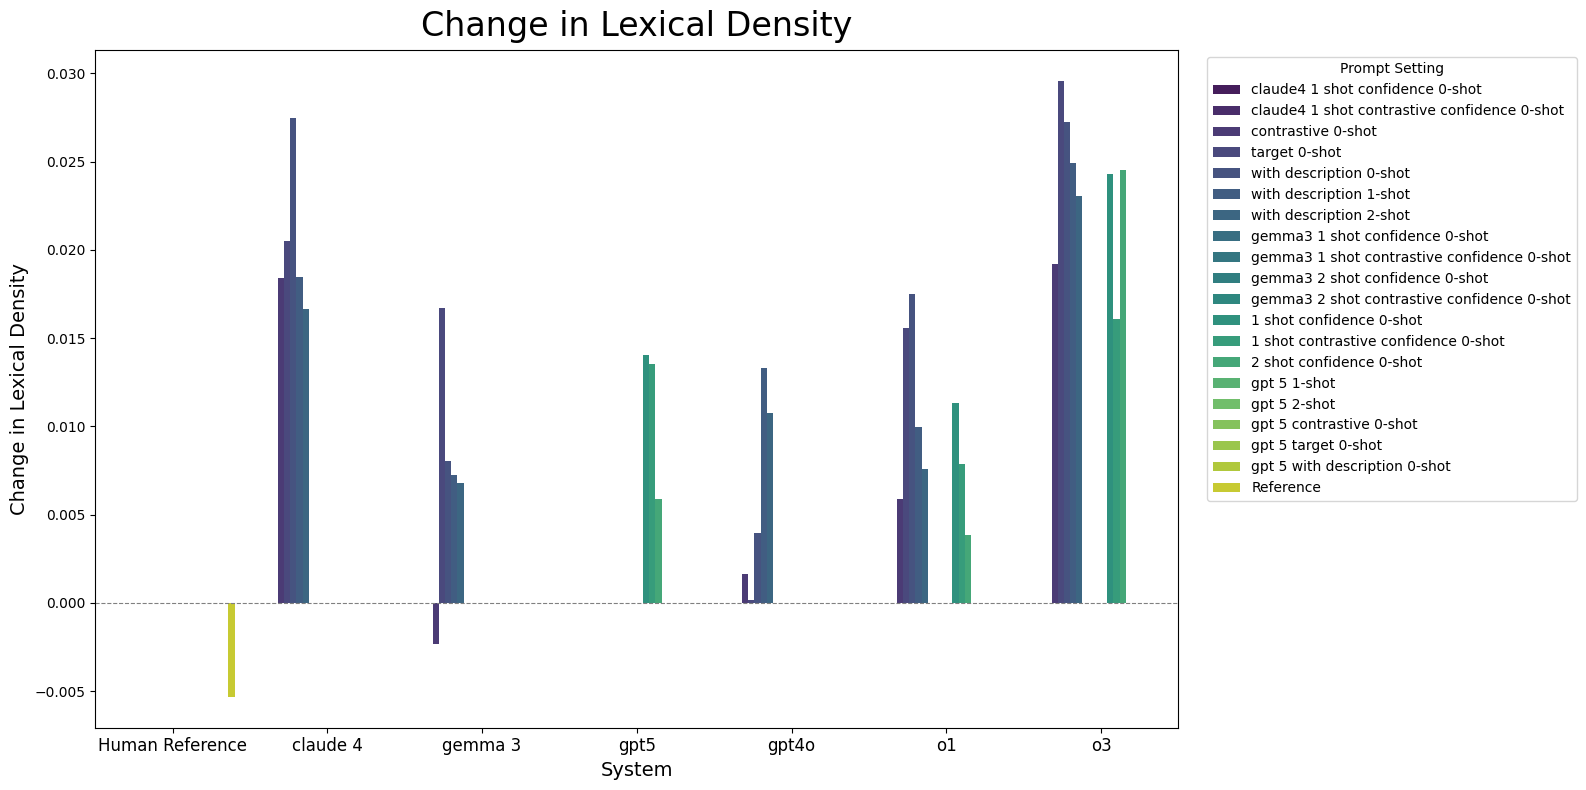

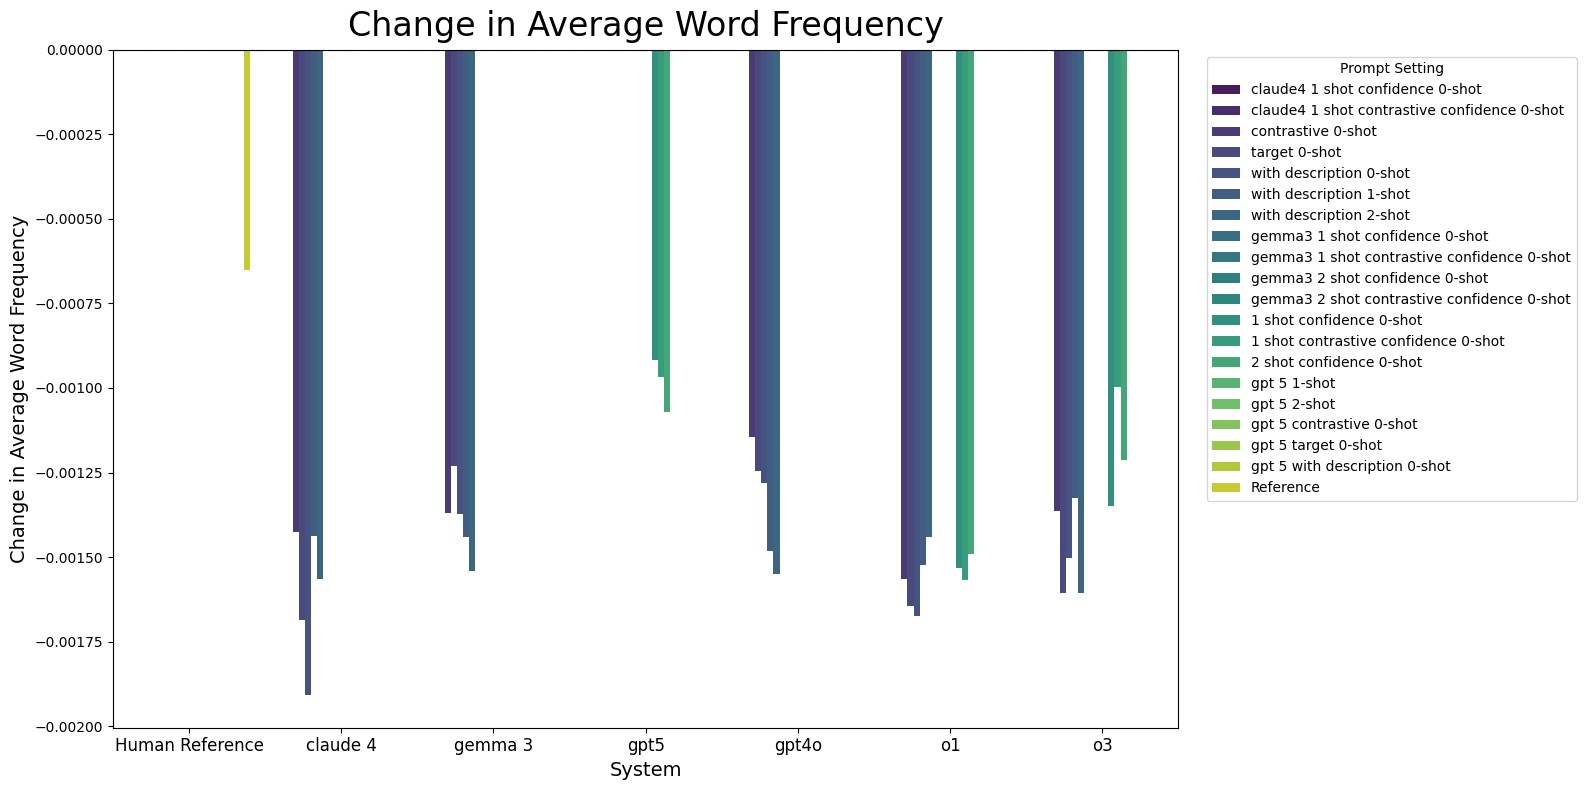

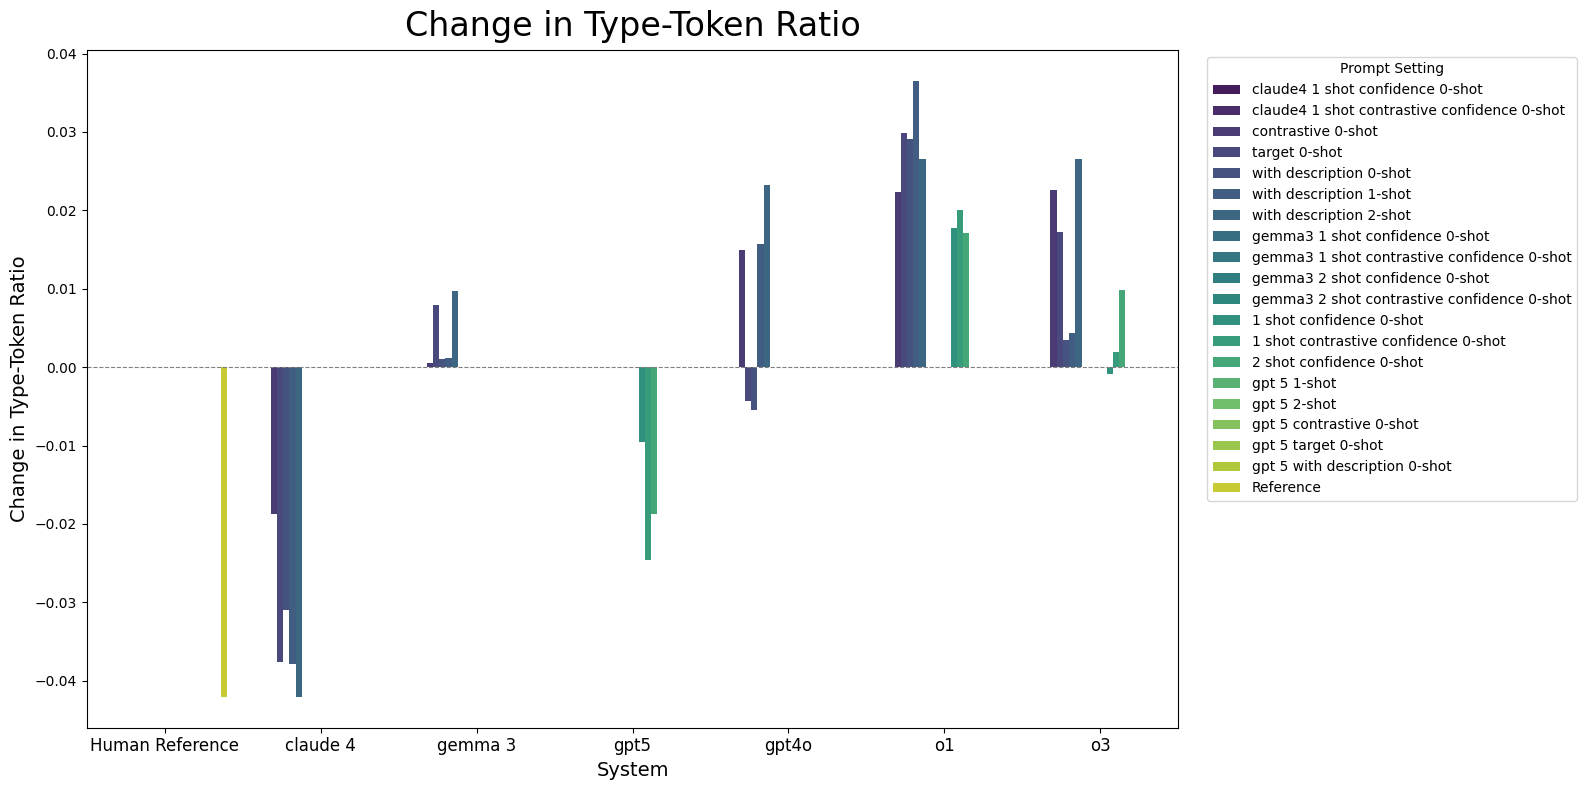

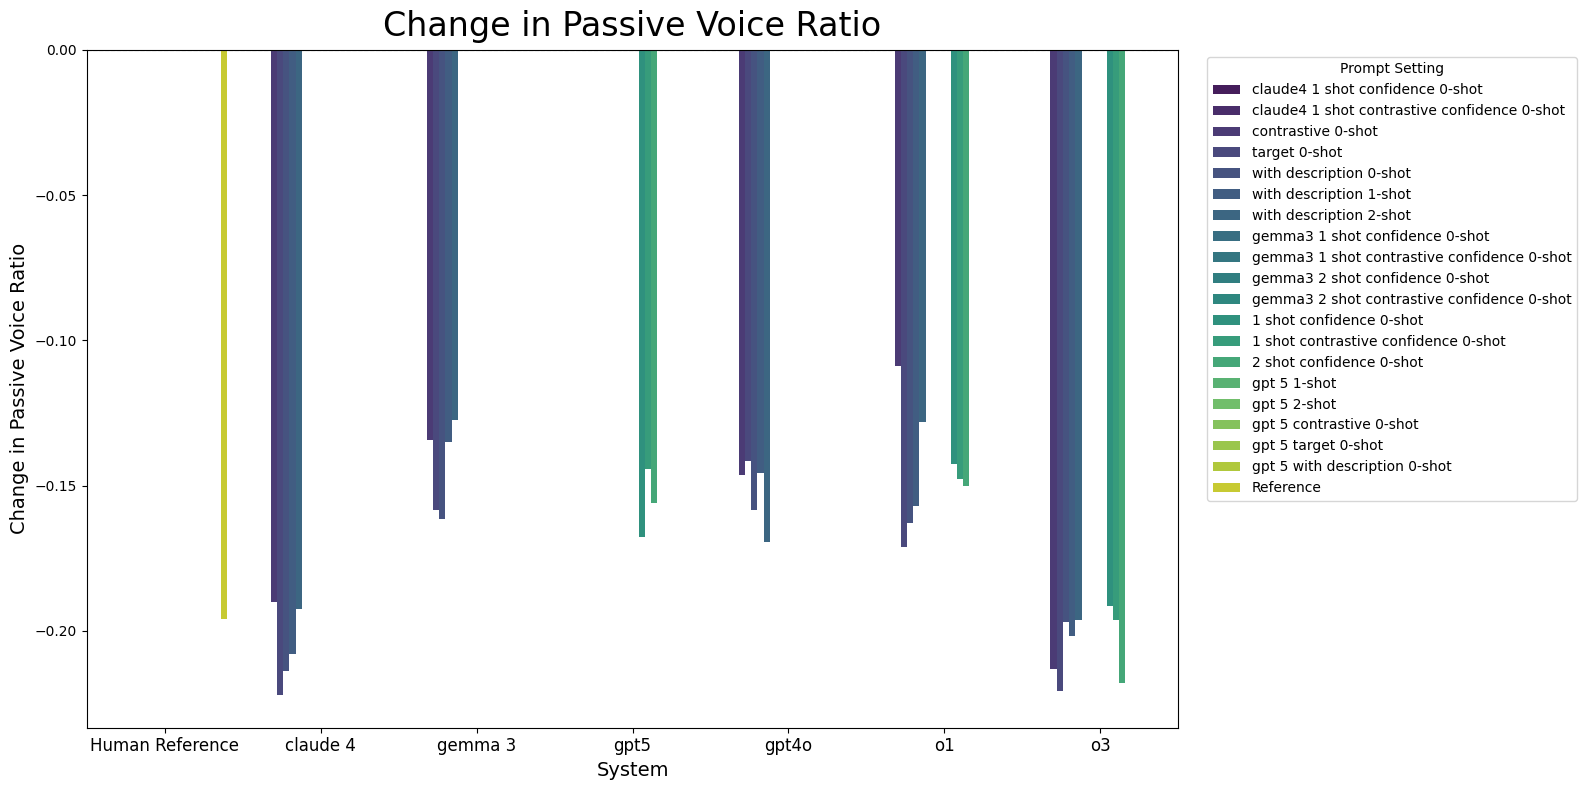

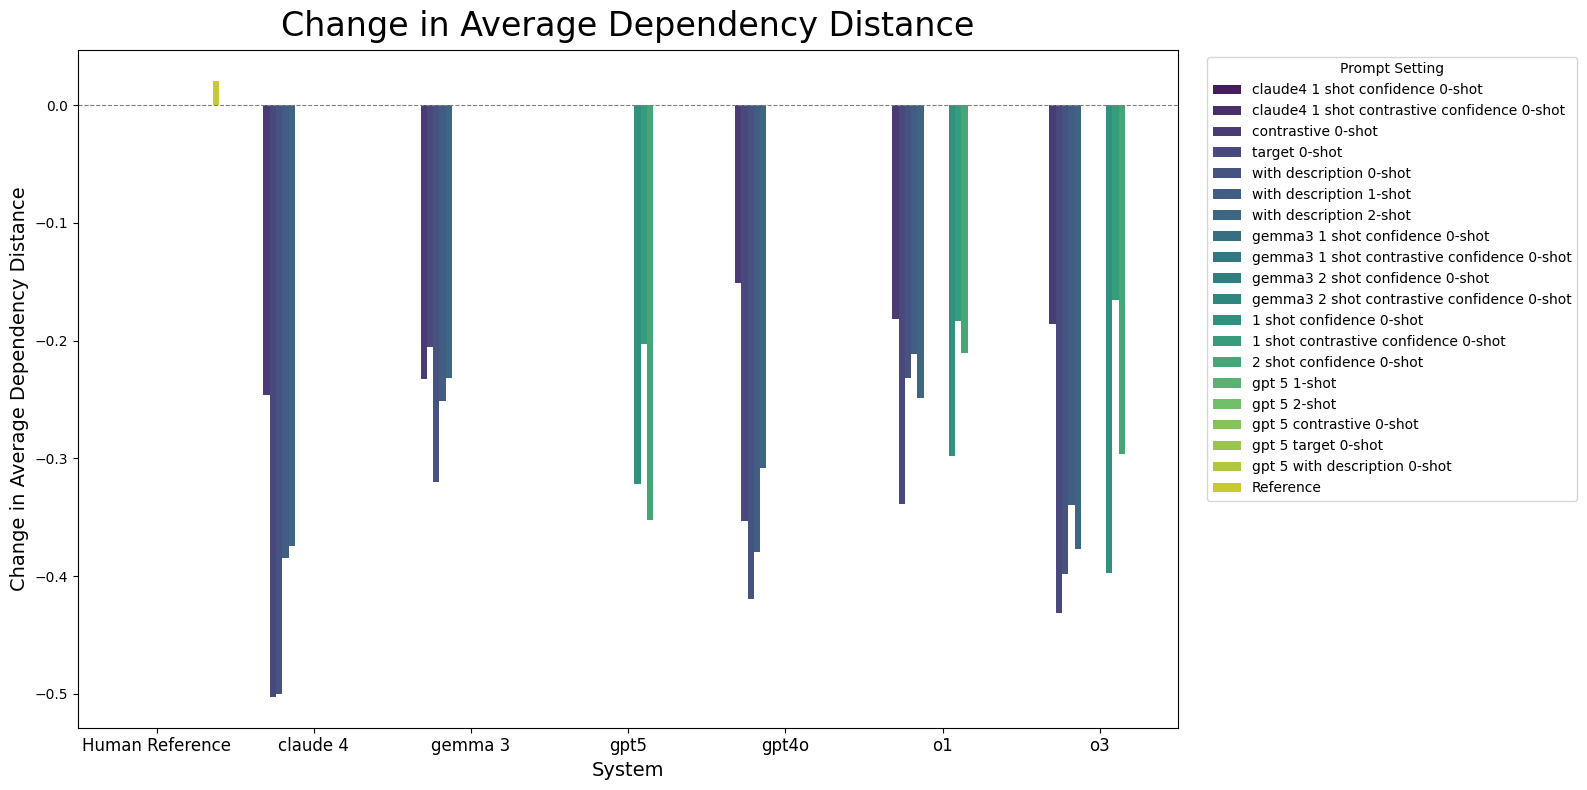

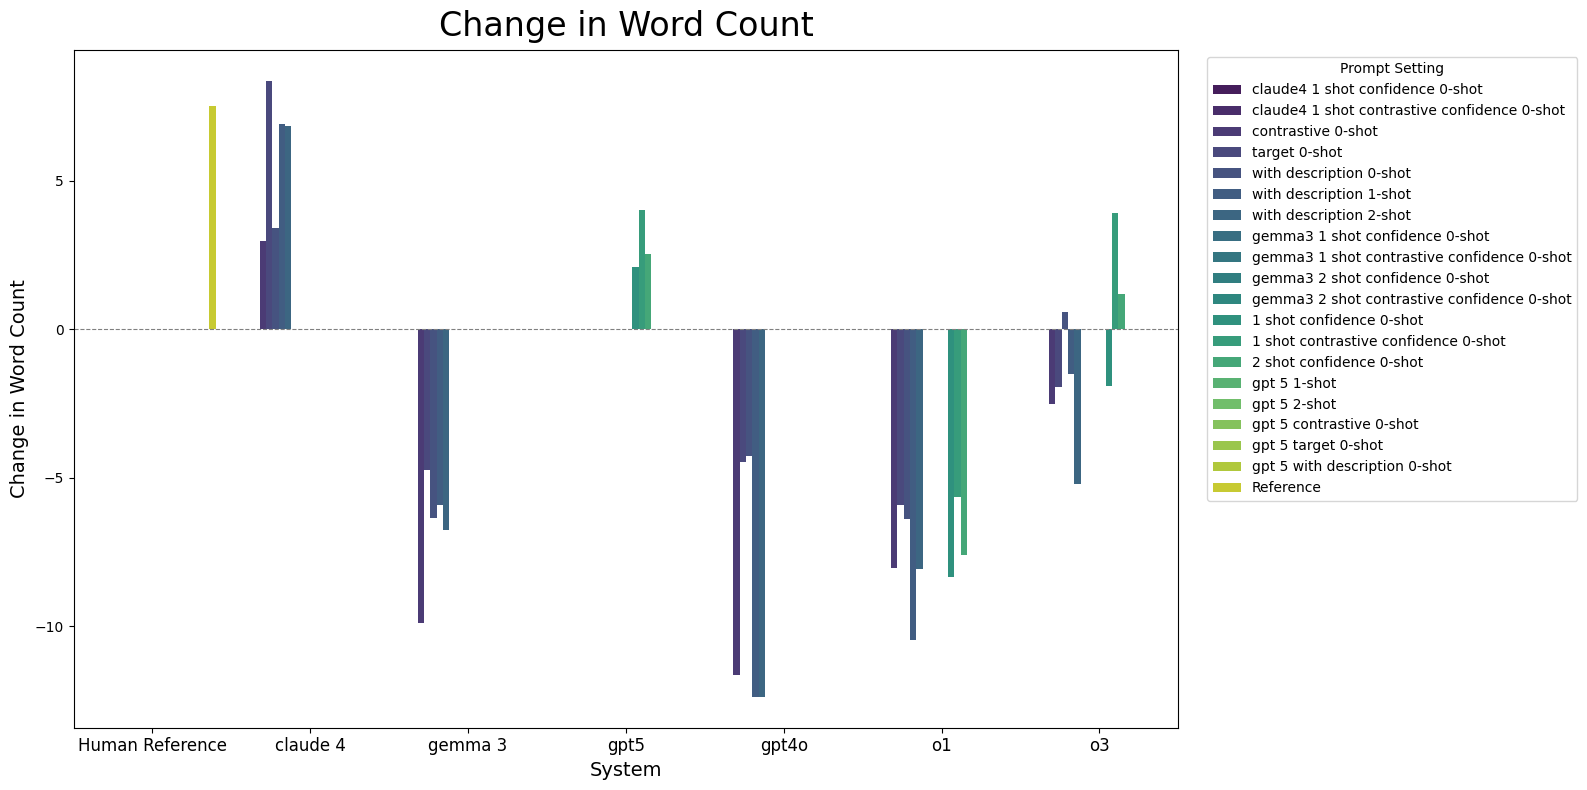

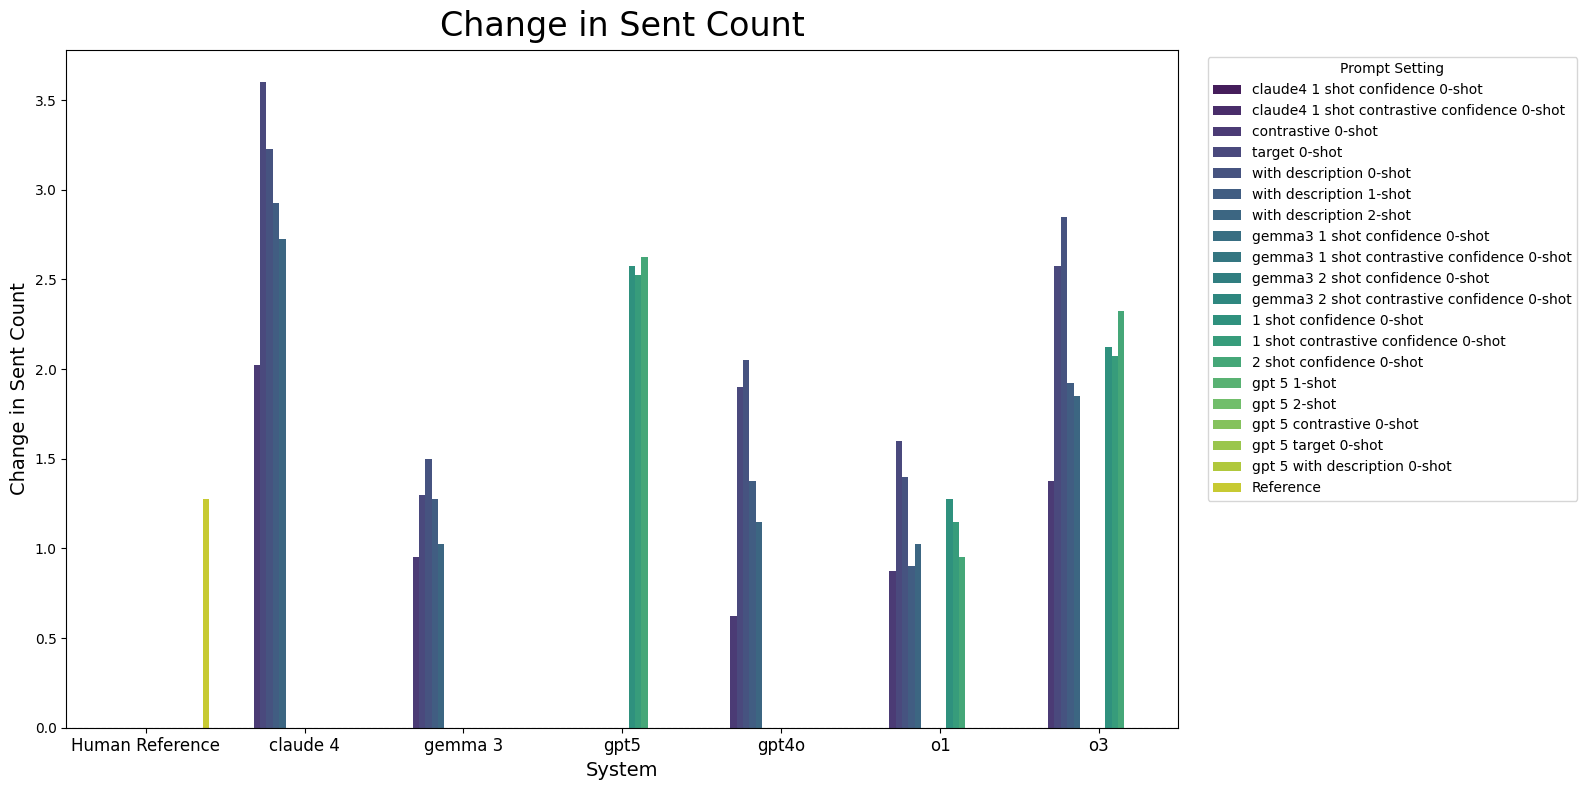

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Define more direct labels for all 7 features ---
feature_labels = {
    'readability': 'Change in Readability Score',
    'avg_sent_len': 'Change in Average Sentence Length',
    'lexical_density': 'Change in Lexical Density',
    'avg_word_freq': 'Change in Average Word Frequency',
    'ttr': 'Change in Type-Token Ratio',
    'passive_ratio': 'Change in Passive Voice Ratio',
    'avg_dep_dist': 'Change in Average Dependency Distance'
}

# --- PREPARE FOR GROUPING ---
# 1. Define the main system names for grouping.
systems = ['gpt5', 'claude 4', 'gemma 3', 'gpt4o', 'o1', 'o3', 'Human Reference']

# 2. Define a function to extract System and Setting from the full name.
def extract_info(name):
    for system in systems:
        if name.startswith(system):
            setting = name.replace(system, '', 1).strip()
            # If the setting is empty (like for 'Human Reference'), give it a standard label.
            return system, setting if setting else 'Reference'
    return 'Other', name # Fallback for any names that don't match

# 3. Define a consistent order for the systems on the x-axis.
system_order = ['Human Reference', 'claude 4', 'gemma 3', 'gpt5', 'gpt4o', 'o1', 'o3']

# --- Automated Bar Plots (New Grouped Logic) ---
# Assuming FEATURE_LIST and delta_df are defined elsewhere in your code
for feature in FEATURE_LIST:
    # --- STEP 1: Get and Restructure the Data ---
    
    # Get the raw data for the current feature
    deltas = delta_df.filter(like=f'{feature}_delta').mean()
    
    # Convert to a DataFrame
    tmp_df = deltas.reset_index()
    tmp_df.columns = ['FullName', 'Value']
    
    # Clean the full name (same logic as before, but on a column)
    tmp_df['FullName'] = tmp_df['FullName'].str.replace(f'{feature}_delta_', '').str.replace('_', ' ').str.replace('human reference', 'Human Reference')
    
    # Create the 'System' and 'Setting' columns using the function
    tmp_df[['System', 'Setting']] = tmp_df['FullName'].apply(extract_info).apply(pd.Series)

    # --- STEP 2: Create the Grouped Plot ---
    
    plt.figure(figsize=(16, 8))
    
    # Use x='System' and hue='Setting' to create the grouped bar chart
    barplot = sns.barplot(
        data=tmp_df,
        x='System',
        y='Value',
        hue='Setting',
        order=system_order, # Enforce the logical order
        palette='viridis'   # Or another categorical palette like 'mako' or 'rocket'
    )
    
    # Add a horizontal line at y=0 for reference
    plt.axhline(0, color='grey', linewidth=0.8, linestyle='--')
    
    # --- STEP 3: Polish the Plot ---
    
    # Use the feature_labels dictionary for a clean title and y-axis label
    current_feature_label = feature_labels.get(feature, f'Change in {feature.replace("_", " ").title()}')
    plt.title(f'{current_feature_label}', fontsize=24, pad=10)
    plt.xlabel('System', fontsize=14)
    plt.ylabel(current_feature_label, fontsize=14)
    plt.xticks(fontsize=12)
    
    # Move the legend outside the plot for clarity
    plt.legend(title='Prompt Setting', bbox_to_anchor=(1.02, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

In [8]:
# --- Reshape Deltas ---
long_deltas = delta_df.filter(like='_delta_').melt(
    var_name='delta_name', 
    value_name='delta_value', 
    ignore_index=False
).reset_index()
# This part correctly extracts the feature name and the full setup_id
long_deltas['feature'] = long_deltas['delta_name'].apply(lambda x: x.split('_delta_')[0])
long_deltas['setup_id'] = long_deltas['delta_name'].apply(lambda x: x.split('_delta_')[1])

# --- Reshape Scores ---
score_cols = [c for c in final_df.columns if any(m in c for m in ['meaningbert', 'bertscore'])]
long_scores = final_df[score_cols].melt(
    var_name='score_name', 
    value_name='score_value', 
    ignore_index=False
).reset_index()

# CORRECTED LOGIC: This now correctly parses the full setup_id from score names
score_metrics_list = ['bertscore_f1_ref', 'meaningbert_ref', 'bertscore_f1_orig', 'meaningbert_orig']
def parse_score_name(name):
    for metric in score_metrics_list:
        if name.startswith(metric):
            # Return the metric and the rest of the string, which is the setup_id
            return metric, name[len(metric)+1:]
    return None, None

parsed_info = long_scores['score_name'].apply(parse_score_name).apply(pd.Series)
parsed_info.columns = ['metric', 'setup_id']
long_scores['metric'] = parsed_info['metric']
long_scores['setup_id'] = parsed_info['setup_id']


# --- Merge into a single long-format DataFrame ---
long_analysis_df = pd.merge(
    long_deltas[['text_id', 'setup_id', 'feature', 'delta_value']],
    long_scores[['text_id', 'setup_id', 'metric', 'score_value']],
    on=['text_id', 'setup_id']
)

# This should now have data
if long_analysis_df.empty:
    print("Error: The DataFrame is still empty. There might be another issue.")
else:
    print("Long-format DataFrame for analysis created successfully!")
    display(long_analysis_df.head())

Long-format DataFrame for analysis created successfully!


text_id                          setup_id      feature  delta_value  \
0   01-a2  claude4_1_shot_confidence_0-shot  readability    -7.570471   
1   01-a2  claude4_1_shot_confidence_0-shot  readability    -7.570471   
2   01-a2  claude4_1_shot_confidence_0-shot  readability    -7.570471   
3   01-a2  claude4_1_shot_confidence_0-shot  readability    -7.570471   
4   01-b1  claude4_1_shot_confidence_0-shot  readability    -5.833167   

              metric score_value  
0   meaningbert_orig      0.7358  
1  bertscore_f1_orig      0.9303  
2    meaningbert_ref      0.8398  
3   bertscore_f1_ref      0.9339  
4   meaningbert_orig      0.8204

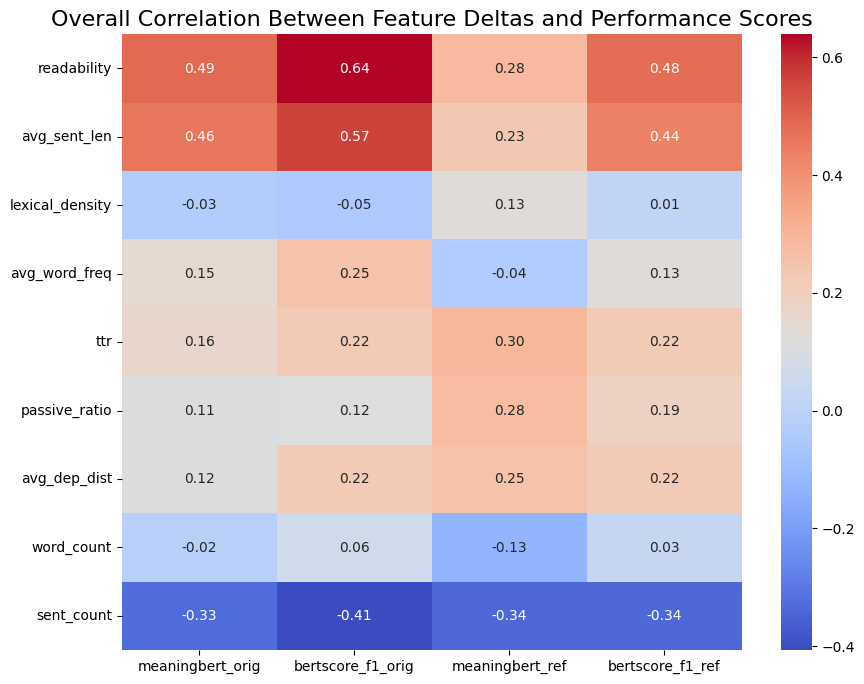

In [9]:
# Pivot the table to create a correlation matrix
corr_df = long_analysis_df.pivot_table(
    index=['text_id', 'setup_id'], 
    columns=['feature', 'metric'], 
    values=['delta_value', 'score_value']
)

# We need to flatten the multi-level columns and then select the right ones for correlation
# First, let's get the delta and score values into a flat structure
pivoted_for_corr = long_analysis_df.pivot_table(
    index=['text_id', 'setup_id'], 
    columns='feature', 
    values='delta_value'
).join(
    long_analysis_df.pivot_table(
        index=['text_id', 'setup_id'], 
        columns='metric', 
        values='score_value'
    )
)

# Calculate the correlation matrix
correlation_matrix = pivoted_for_corr.corr()

# We only want to see the correlation between deltas and scores
delta_cols = long_analysis_df['feature'].unique()
score_cols = long_analysis_df['metric'].unique()
final_corr = correlation_matrix.loc[delta_cols, score_cols]

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(final_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Overall Correlation Between Feature Deltas and Performance Scores', fontsize=16)
plt.show()

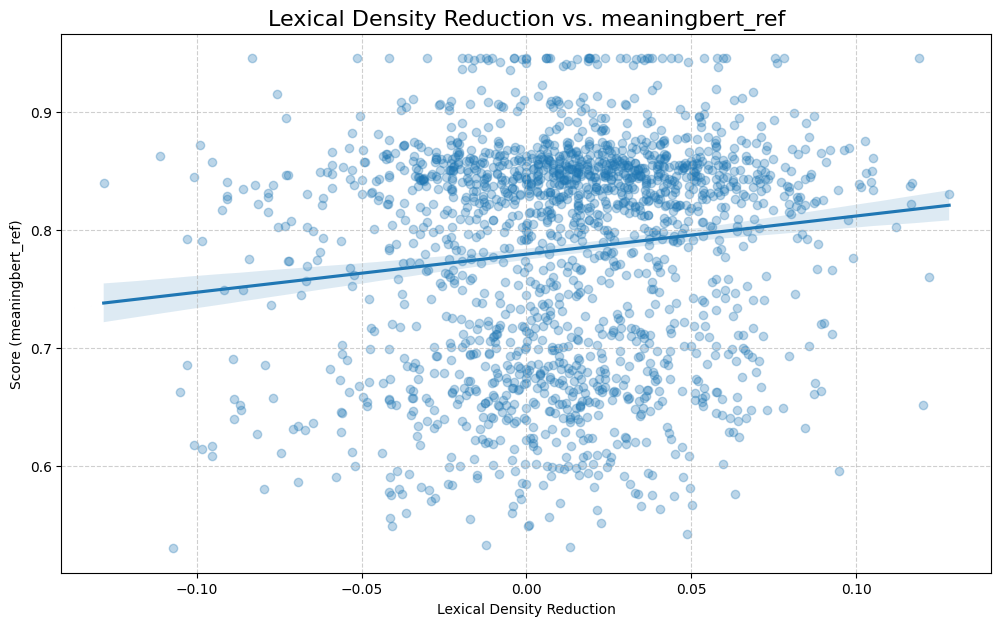

In [10]:
# Let's plot the overall trend for one feature vs. one score
feature_to_plot = 'lexical_density'
score_to_plot = 'meaningbert_ref'

# Filter the long dataframe for the specific data we want
plot_data = long_analysis_df[
    (long_analysis_df['feature'] == feature_to_plot) &
    (long_analysis_df['metric'] == score_to_plot)
].copy()

# Ensure data is numeric
plot_data['delta_value'] = pd.to_numeric(plot_data['delta_value'], errors='coerce')
plot_data['score_value'] = pd.to_numeric(plot_data['score_value'], errors='coerce')

plt.figure(figsize=(12, 7))
# Create the scatter plot with points colored by system
# The regression line will be for ALL points combined
sns.regplot(
    data=plot_data, 
    x='delta_value', 
    y='score_value',
    scatter_kws={'alpha': 0.3} # Make points transparent to see density
)

plt.title(f'{feature_to_plot.replace("_", " ").title()} Reduction vs. {score_to_plot}', fontsize=16)
plt.xlabel(f'{feature_to_plot.replace("_", " ").title()} Reduction')
plt.ylabel(f'Score ({score_to_plot})')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [11]:
# --- Reshape Simplified Text Features ---
simplified_features = features_df.filter(like='_simplified_').copy()
long_features = simplified_features.melt(
    var_name='feature_name_full', 
    value_name='feature_value', 
    ignore_index=False
).reset_index()

long_features['feature'] = long_features['feature_name_full'].apply(lambda x: x.split('_simplified_')[0])
long_features['setup_id'] = long_features['feature_name_full'].apply(lambda x: x.split('_simplified_')[1])

# --- Reshape Predicted CEFR ---
predicted_cefrs = final_df.filter(like='predicted_cefr_').copy()
long_cefrs = predicted_cefrs.melt(
    var_name='cefr_name_full', 
    value_name='predicted_cefr', 
    ignore_index=False
).reset_index()

long_cefrs['setup_id'] = long_cefrs['cefr_name_full'].apply(lambda x: x.replace('predicted_cefr_', ''))

# --- Merge into a single analysis DataFrame ---
cefr_analysis_df = pd.merge(
    long_features[['text_id', 'setup_id', 'feature', 'feature_value']],
    long_cefrs[['text_id', 'setup_id', 'predicted_cefr']],
    on=['text_id', 'setup_id']
)

# Clean up and convert to numeric, dropping any rows with missing values
cefr_analysis_df['feature_value'] = pd.to_numeric(cefr_analysis_df['feature_value'], errors='coerce')
cefr_analysis_df.dropna(subset=['feature_value', 'predicted_cefr'], inplace=True)


print("DataFrame for CEFR analysis created successfully!")
display(cefr_analysis_df.head())

DataFrame for CEFR analysis created successfully!


text_id                          setup_id        feature  feature_value  \
0   01-a2  claude4_1_shot_confidence_0-shot  avg_word_freq       0.004343   
1   01-b1  claude4_1_shot_confidence_0-shot  avg_word_freq       0.006635   
2   02-a2  claude4_1_shot_confidence_0-shot  avg_word_freq       0.004131   
3   02-b1  claude4_1_shot_confidence_0-shot  avg_word_freq       0.002261   
4   03-a2  claude4_1_shot_confidence_0-shot  avg_word_freq       0.009776   

  predicted_cefr  
0             A2  
1             A2  
2             A2  
3             A2  
4             A2

/tmp/ipykernel_12556/879970663.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


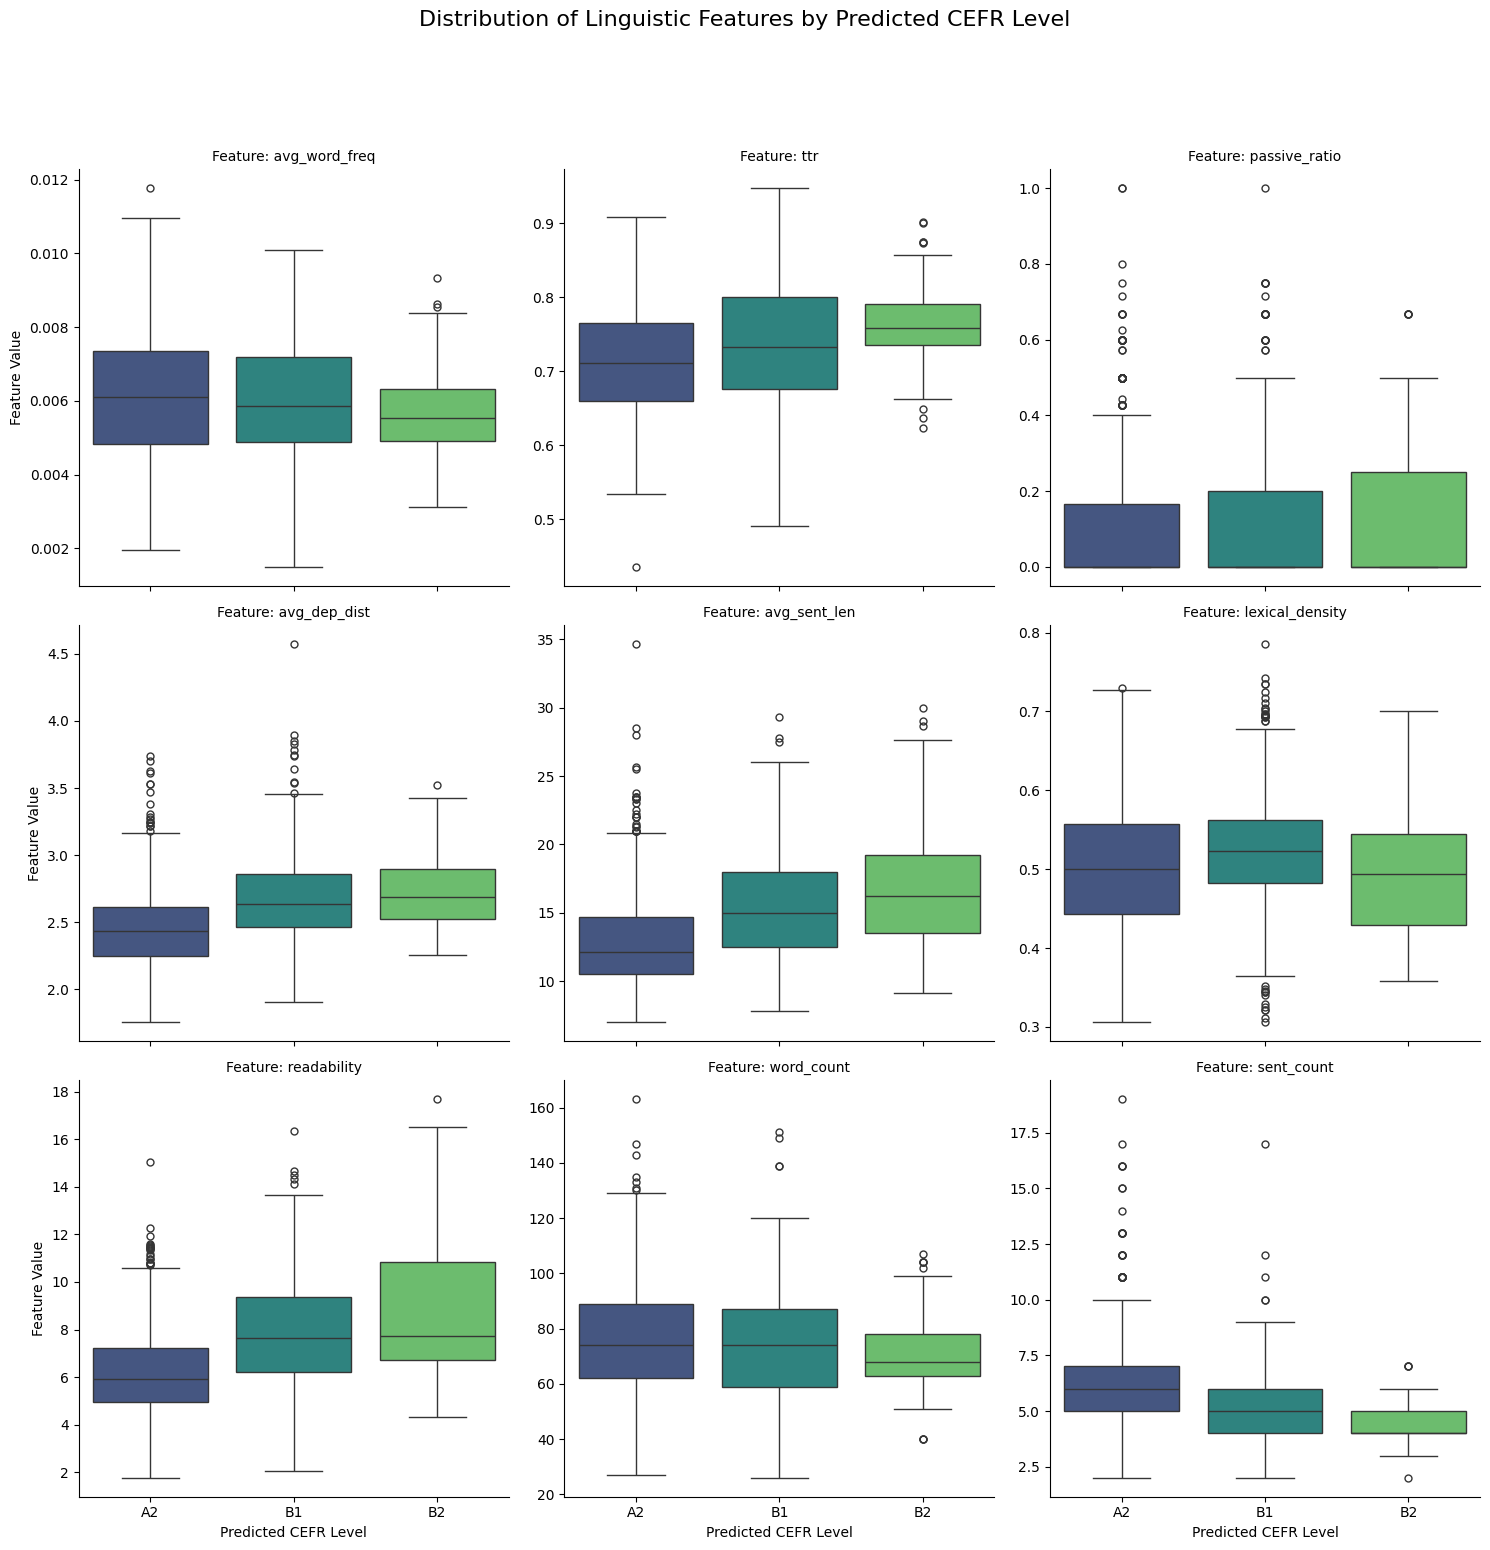

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the order of CEFR levels for plotting
cefr_order = sorted(cefr_analysis_df['predicted_cefr'].unique())

# Use catplot to create a grid of box plots, one for each feature
g = sns.catplot(
    data=cefr_analysis_df,
    x='predicted_cefr',
    y='feature_value',
    col='feature', # This creates a separate subplot for each feature
    kind='box',
    order=cefr_order,
    sharey=False, # Allow each subplot to have its own y-axis scale
    col_wrap=3, # Wrap the plots into a grid with 3 columns
    palette='viridis'
)

g.fig.suptitle('Distribution of Linguistic Features by Predicted CEFR Level', y=1.03, fontsize=16)
g.set_axis_labels("Predicted CEFR Level", "Feature Value")
g.set_titles("Feature: {col_name}")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

Spearman Correlation of Features with Predicted CEFR Level:


Spearman Correlation       P-Value
Feature                                            
avg_word_freq               -0.056947  1.567675e-02
ttr                          0.182309  6.454249e-15
passive_ratio                0.087139  2.143498e-04
avg_dep_dist                 0.369740  2.047032e-59
avg_sent_len                 0.381241  2.355696e-63
lexical_density              0.084006  3.598419e-04
readability                  0.397264  4.110107e-69
word_count                  -0.062741  7.752712e-03
sent_count                  -0.381261  2.317875e-63

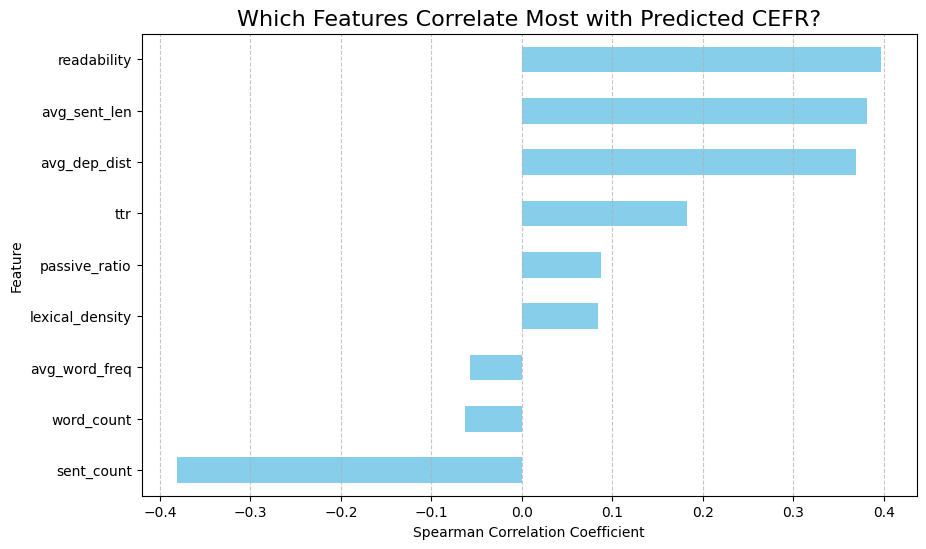

In [13]:
from scipy.stats import spearmanr
import pandas as pd

# --- 1. Prepare the Data ---
# We'll use the cefr_analysis_df from the previous step.

# Create a mapping to convert CEFR labels into numerical ranks
cefr_rank_map = {'A1': 1, 'A2': 2, 'B1': 3, 'B2': 4, 'C1': 5, 'C2': 6}
cefr_analysis_df['cefr_rank'] = cefr_analysis_df['predicted_cefr'].map(cefr_rank_map)

# Drop any rows where mapping might have failed
cefr_analysis_df.dropna(subset=['cefr_rank'], inplace=True)

# --- 2. Calculate Correlations ---
correlation_results = []
features_to_correlate = cefr_analysis_df['feature'].unique()

for feature in features_to_correlate:
    # Isolate the data for the current feature
    feature_data = cefr_analysis_df[cefr_analysis_df['feature'] == feature]
    
    # Calculate Spearman's rank correlation
    # It returns the correlation coefficient and the p-value
    corr, p_value = spearmanr(feature_data['cefr_rank'], feature_data['feature_value'])
    
    correlation_results.append({
        'Feature': feature,
        'Spearman Correlation': corr,
        'P-Value': p_value
    })

# Create a DataFrame to display the results nicely
corr_df = pd.DataFrame(correlation_results).set_index('Feature')

print("Spearman Correlation of Features with Predicted CEFR Level:")
display(corr_df)

# --- 3. Visualize the Correlations ---
plt.figure(figsize=(10, 6))
corr_df['Spearman Correlation'].sort_values().plot(kind='barh', color='skyblue')
plt.title('Which Features Correlate Most with Predicted CEFR?', fontsize=16)
plt.xlabel('Spearman Correlation Coefficient')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

/tmp/ipykernel_12556/1422949344.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_series.index, y=corr_series.values, palette='coolwarm')


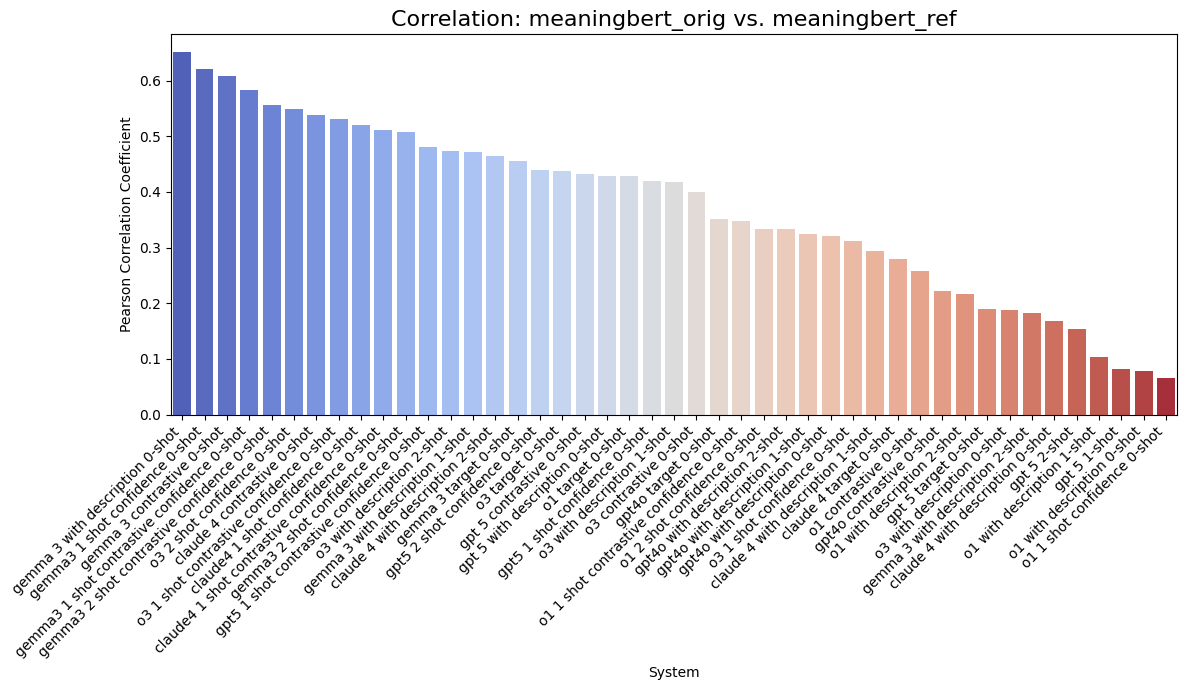

/tmp/ipykernel_12556/1422949344.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_series.index, y=corr_series.values, palette='coolwarm')


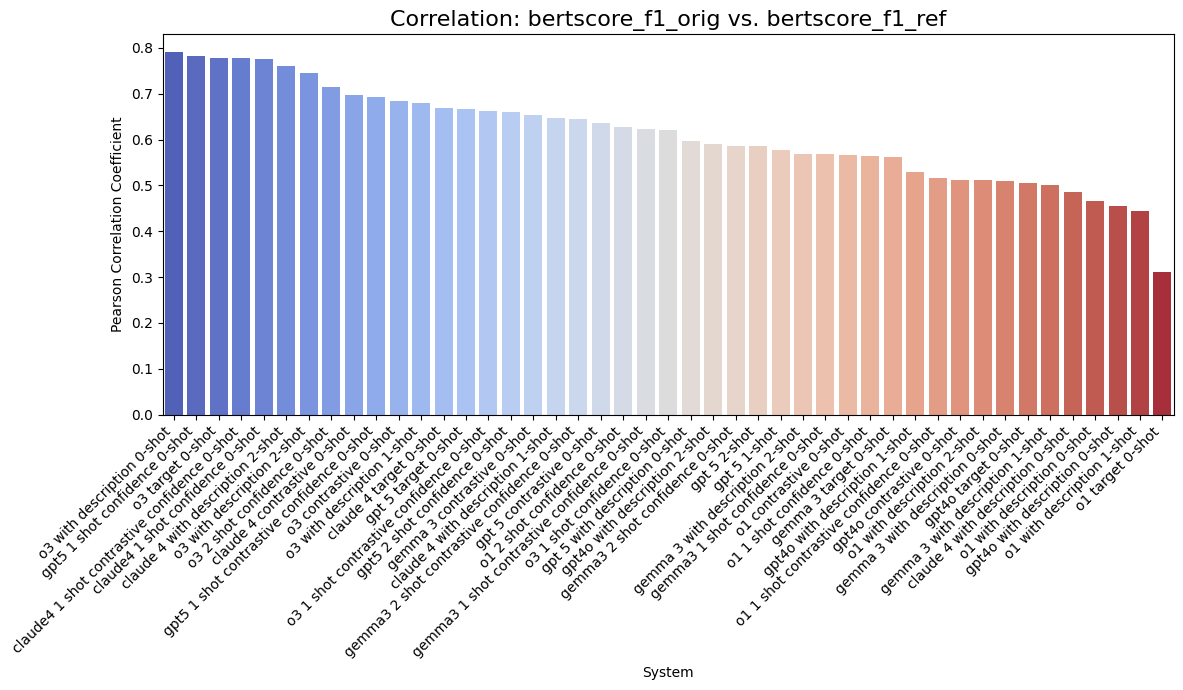

/tmp/ipykernel_12556/1422949344.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_series.index, y=corr_series.values, palette='coolwarm')


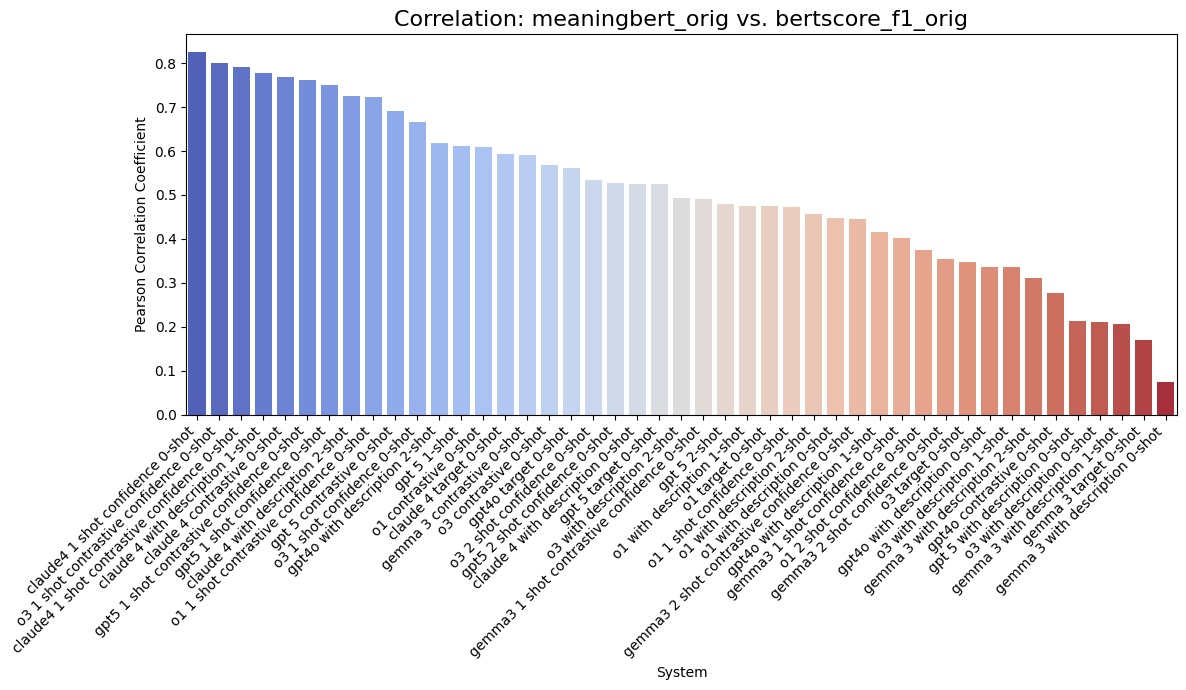

/tmp/ipykernel_12556/1422949344.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_series.index, y=corr_series.values, palette='coolwarm')


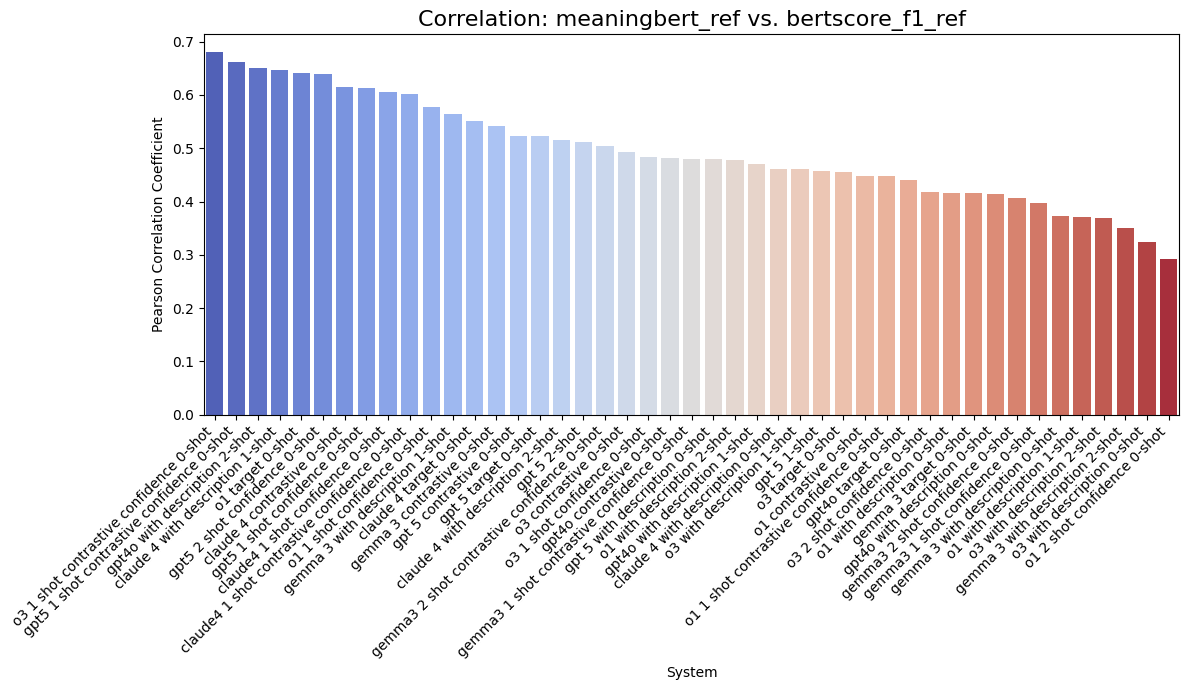

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the pairs of metrics you want to correlate
metric_pairs = [
    ('meaningbert_orig', 'meaningbert_ref'),
    ('bertscore_f1_orig', 'bertscore_f1_ref'),
    ('meaningbert_orig', 'bertscore_f1_orig'),
    ('meaningbert_ref', 'bertscore_f1_ref')
]

# Get a unique list of all your systems
systems_to_plot = df['setup_id'].unique()

# Loop through each pair of metrics to create a dedicated bar plot
for x_metric, y_metric in metric_pairs:
    
    correlations = {} # Dictionary to store the correlation for each system
    
    # Loop through each system to calculate its correlation
    for system in systems_to_plot:
        x_col = f"{x_metric}_{system}"
        y_col = f"{y_metric}_{system}"

        # Ensure both columns exist for this system
        if not all(c in final_df.columns for c in [x_col, y_col]):
            continue
            
        # Create a temporary DataFrame and drop rows missing either score
        temp_df = final_df[[x_col, y_col]].copy()
        temp_df[x_col] = pd.to_numeric(temp_df[x_col], errors='coerce')
        temp_df[y_col] = pd.to_numeric(temp_df[y_col], errors='coerce')
        temp_df.dropna(inplace=True)

        if len(temp_df) < 2:
            correlations[system] = np.nan # Not enough data to correlate
            continue

        # Calculate the correlation and store it
        # .corr() returns a matrix, so we get the specific value with .iloc[0, 1]
        corr_value = temp_df.corr().iloc[0, 1]
        correlations[system] = corr_value
        
    # --- Create the Bar Plot ---
    # Convert the dictionary to a sorted pandas Series for plotting
    corr_series = pd.Series(correlations).sort_values(ascending=False)
    corr_series.index = [idx.replace('_', ' ') for idx in corr_series.index]

    plt.figure(figsize=(12, 7))
    sns.barplot(x=corr_series.index, y=corr_series.values, palette='coolwarm')
    
    plt.title(f'Correlation: {x_metric} vs. {y_metric}', fontsize=16)
    plt.ylabel('Pearson Correlation Coefficient')
    plt.xlabel('System')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# --- Step 1: Add Target CEFR to the Final DataFrame ---
if 'target_cefr' not in final_df:
    target_cefr_info = df[['text_id', 'target_cefr']].drop_duplicates().set_index('text_id')
    final_df = final_df.join(target_cefr_info)

# --- Step 2: Create Faceted Scatter Plots ---
metric_pairs = [
    ('meaningbert_orig', 'meaningbert_ref'),
    ('bertscore_f1_orig', 'bertscore_f1_ref')
]
systems_to_plot = df['setup_id'].unique()

# for system in systems_to_plot:
#     for x_metric, y_metric in metric_pairs:
        
#         x_col = f"{x_metric}_{system}"
#         y_col = f"{y_metric}_{system}"
#         cefr_col = f"predicted_cefr_{system}"
#         target_col = 'target_cefr'

#         if not all(c in final_df.columns for c in [x_col, y_col, cefr_col, target_col]):
#             continue
            
#         plot_df = final_df[[x_col, y_col, cefr_col, target_col]].copy()
#         plot_df[x_col] = pd.to_numeric(plot_df[x_col], errors='coerce')
#         plot_df[y_col] = pd.to_numeric(plot_df[y_col], errors='coerce')
#         plot_df.dropna(subset=[x_col, y_col, cefr_col, target_col], inplace=True)

#         if plot_df.empty:
#             continue
        
#         hue_order = sorted(plot_df[cefr_col].unique())

#         g = sns.relplot(
#             data=plot_df, x=x_col, y=y_col,
#             hue=cefr_col, col=target_col, kind='scatter',
#             hue_order=hue_order, palette='viridis', alpha=0.7,
#             height=6, aspect=1
#         )
        
#         # --- Align Axes Across All Subplots ---
#         # 1. Find the global min and max limits across all subplots
#         global_min = float('inf')
#         global_max = float('-inf')
#         for ax in g.axes.flat:
#             global_min = min(global_min, ax.get_xlim()[0], ax.get_ylim()[0])
#             global_max = max(global_max, ax.get_xlim()[1], ax.get_ylim()[1])
        
#         # 2. Apply the global limits and the 45-degree line to each subplot
#         for ax in g.axes.flat:
#             ax.plot([global_min, global_max], [global_min, global_max], 'k--', alpha=0.75, zorder=0)
#             ax.set_xlim(global_min, global_max)
#             ax.set_ylim(global_min, global_max)
#             ax.grid(True, linestyle='--', alpha=0.6)
        
#         g.fig.suptitle(f'Trade-off for: {system.replace("_", " ")}', y=1.03, fontsize=16)
#         g.set_axis_labels(f'Similarity to Original ({x_metric})', f'Similarity to Reference ({y_metric})')
#         g.set_titles("Target: {col_name}")
#         plt.show()

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Step 1: Calculate all matrices and find the global max value ---
systems_to_plot = df['setup_id'].unique()
all_cefr_labels = sorted(
    pd.concat([final_df['target_cefr']] + 
              [final_df[col] for col in final_df.filter(like='predicted_cefr_')])
    .dropna().unique()
)

all_matrices = {}
global_max = 0

for system in systems_to_plot:
    target_col = 'target_cefr'
    predicted_col = f'predicted_cefr_{system}'

    if predicted_col not in final_df.columns:
        continue
    
    plot_df = final_df[[target_col, predicted_col]].dropna()

    if plot_df.empty:
        continue

    # Calculate the confusion matrix
    cm = confusion_matrix(plot_df[target_col], plot_df[predicted_col], labels=all_cefr_labels)
    
    # Store the matrix and update the global max value
    all_matrices[system] = cm
    if cm.max() > global_max:
        global_max = cm.max()

# --- Step 2: Loop again to plot each matrix with the shared scale ---
# for system, cm in all_matrices.items():
    
#     # Create a DataFrame from the stored matrix for plotting
#     cm_df = pd.DataFrame(cm, index=all_cefr_labels, columns=all_cefr_labels)
    
#     plt.figure(figsize=(7, 5))
#     sns.heatmap(
#         cm_df, 
#         annot=True,
#         fmt='d',
#         cmap='Blues',
#         vmin=0,           # Set the minimum of the color scale
#         vmax=global_max   # Set the maximum of the color scale
#     )
    
#     plt.title(f'Confusion Matrix for:\n{system.replace("_", " ")}', fontsize=15)
#     plt.xlabel('Predicted CEFR Level')
#     plt.ylabel('True Target CEFR Level')
#     plt.show()

In [17]:
from difflib import SequenceMatcher
from IPython.display import HTML, display, Markdown
import spacy

# Load spaCy tokenizer
nlp = spacy.load("en_core_web_sm")

def render_inline_diff(text_a, text_b):
    # Tokenize by word (filter out whitespace)
    tokens_a = [t.text for t in nlp(text_a) if not t.is_space]
    tokens_b = [t.text for t in nlp(text_b) if not t.is_space]

    # Compute diff using SequenceMatcher
    sm = SequenceMatcher(None, tokens_a, tokens_b)
    html = []

    for tag, i1, i2, j1, j2 in sm.get_opcodes():
        if tag == "equal":
            html.append(" ".join(tokens_a[i1:i2]) + " ")
        elif tag == "delete":
            deleted = " ".join(tokens_a[i1:i2])
            html.append(f"<span style='color:red;text-decoration:line-through;'>{deleted}</span> ")
        elif tag == "insert":
            inserted = " ".join(tokens_b[j1:j2])
            html.append(f"<span style='color:green;background-color:#eaffea;'>{inserted}</span> ")
        elif tag == "replace":
            deleted = " ".join(tokens_a[i1:i2])
            inserted = " ".join(tokens_b[j1:j2])
            html.append(
                f"<span style='color:red;text-decoration:line-through;'>{deleted}</span> "
                f"<span style='color:green;background-color:#eaffea;'>{inserted}</span> "
            )

    html_str = " ".join(html)
    display(HTML(f"<div style='font-family:monospace; line-height:1.6em'>{html_str}</div>"))

In [18]:
def display_diff_across_text_ids(text_id_a, col_a_name, text_id_b, col_b_name, df_wide):
    """
    Displays a visual diff between the text from two different cells in the DataFrame,
    potentially across different text_ids.
    
    Args:
        text_id_a (str): The ID of the first text to analyze.
        col_a_name (str): The name of the column for the first text.
        text_id_b (str): The ID of the second text to analyze.
        col_b_name (str): The name of the column for the second text.
        df_wide (pd.DataFrame): Your wide-format final_df.
    """
    try:
        # Get the text from the first location
        text_a = df_wide.loc[text_id_a, col_a_name]
        # Get the text from the second location
        text_b = df_wide.loc[text_id_b, col_b_name]
    except KeyError as e:
        print(f"Error: Could not find the specified location in the DataFrame. Missing: {e}")
        return

    if not isinstance(text_a, str) or not isinstance(text_b, str):
        print("Error: One or both locations do not contain valid text data.")
        return

    # --- Display the Comparison ---
    display(Markdown(f"## Diff Comparison"))
    display(Markdown(f"### Comparing `{col_a_name}` for `{text_id_a}` (deletions) vs. `{col_b_name}` for `{text_id_b}` (additions)"))
    render_inline_diff(text_a, text_b)

In [19]:
# 1. Compare the human reference for A2 vs. the human reference for B1
print("--- Comparing the two human reference simplifications ---")

display_diff_across_text_ids(
    text_id_a='02-b1',
    col_a_name='original_text',
    text_id_b='02-b1',
    col_b_name='reference_text',
    df_wide=final_df
)

display_diff_across_text_ids(
    text_id_a='02-a2',
    col_a_name='original_text',
    text_id_b='02-a2',
    col_b_name='reference_text',
    df_wide=final_df
)
# # 2. Compare a single system's A2 output vs. its B1 output
# print("\n\n--- Comparing a single system's output for two different target levels ---")
# system_to_compare = 'simplified_claude_4_with_description_1-shot'

# display_diff_across_text_ids(
#     text_id_a='01-b1',
#     col_a_name=system_to_compare,
#     text_id_b='01-a2',
#     col_b_name=system_to_compare,
#     df_wide=final_df
# )

--- Comparing the two human reference simplifications ---


## Diff Comparison

### Comparing `original_text` for `02-b1` (deletions) vs. `reference_text` for `02-b1` (additions)

## Diff Comparison

### Comparing `original_text` for `02-a2` (deletions) vs. `reference_text` for `02-a2` (additions)

In [20]:
from IPython.display import display, Markdown, HTML

def display_full_comparison(text_id, df_wide, sections_to_show='all'):
    """
    For a given text_id, displays selected visual diffs and scores.
    
    Args:
        text_id (str): The ID of the text to analyze.
        df_wide (pd.DataFrame): Your wide-format final_df.
        sections_to_show (str or list): Controls which sections to display.
            Options: 'all', or a list containing any of:
            'ref_vs_orig', 'system_vs_orig', 'system_vs_ref'
    """
    try:
        example_row = df_wide.loc[text_id]
    except KeyError:
        print(f"Error: text_id '{text_id}' not found.")
        return

    original_text = example_row['original_text']
    reference_text = example_row['reference_text']
    systems = df['setup_id'].unique()

    display(Markdown(f"# Comparison for Text ID: {text_id}"))

    # Section 1: Original vs. Human Reference
    if sections_to_show == 'all' or 'ref_vs_orig' in sections_to_show:
        display(Markdown("---"))
        display(Markdown("## Original vs. Human Reference"))
        render_inline_diff(original_text, reference_text)
    
    # Section 2: Original vs. System Outputs
    if sections_to_show == 'all' or 'system_vs_orig' in sections_to_show:
        display(Markdown("---"))
        display(Markdown("## Original vs. System Outputs"))
        for system in systems:
            # ... (code to get and display diffs and scores vs. original) ...
            simplified_col = f'simplified_{system}'
            if simplified_col in example_row and pd.notna(example_row[simplified_col]):
                simplified_text = example_row[simplified_col]
                display(Markdown(f"### Original vs. System: {system.replace('_', ' ')}"))
                m_bert_orig_score = example_row.get(f'meaningbert_orig_{system}', 'N/A')
                b_score_orig_score = example_row.get(f'bertscore_f1_orig_{system}', 'N/A')
                scores_html = f"""<div style='font-size:0.9em; margin-top:5px; margin-bottom:15px; border-left: 3px solid #ccc; padding-left:10px;'><b>Scores (vs. Original):</b><br>MeaningBERT-Orig: <code>{m_bert_orig_score:.4f}</code><br>BERTScore-F1-Orig: <code>{b_score_orig_score:.4f}</code></div>"""
                display(HTML(scores_html))
                render_inline_diff(original_text, simplified_text)

    # Section 3: Human Reference vs. System Outputs
    if sections_to_show == 'all' or 'system_vs_ref' in sections_to_show:
        display(Markdown("---"))
        display(Markdown("## Human Reference vs. System Outputs"))
        for system in systems:
            # ... (code to get and display diffs and scores vs. reference) ...
            simplified_col = f'simplified_{system}'
            if simplified_col in example_row and pd.notna(example_row[simplified_col]):
                simplified_text = example_row[simplified_col]
                display(Markdown(f"### Reference vs. System: {system.replace('_', ' ')}"))
                m_bert_ref_score = example_row.get(f'meaningbert_ref_{system}', 'N/A')
                b_score_ref_score = example_row.get(f'bertscore_f1_ref_{system}', 'N/A')
                scores_html = f"""<div style='font-size:0.9em; margin-top:5px; margin-bottom:15px; border-left: 3px solid #ccc; padding-left:10px;'><b>Scores (vs. Reference):</b><br>MeaningBERT-Ref: <code>{m_bert_ref_score:.4f}</code><br>BERTScore-F1-Ref: <code>{b_score_ref_score:.4f}</code></div>"""
                display(HTML(scores_html))
                render_inline_diff(reference_text, simplified_text)

In [24]:
example_text_id = '02-a2' 

# Example 1: Show only the comparisons against the human reference
print("--- Showing only comparisons against the reference text ---")
display_full_comparison(
    example_text_id, 
    final_df, 
    sections_to_show=['system_vs_orig']
)

# Example 2: Show the original vs. reference, and original vs. systems
# print("\n\n--- Showing comparisons against the original text ---")
# display_full_comparison(
#     example_text_id, 
#     final_df, 
#     sections_to_show=['ref_vs_orig', 'system_vs_orig']
# )

# Example 3: Show everything (the default behavior)
# print("\n\n--- Showing all comparisons ---")
# display_full_comparison(example_text_id, final_df)

--- Showing only comparisons against the reference text ---


# Comparison for Text ID: 02-a2

---

## Original vs. System Outputs

### Original vs. System: gpt4o with description 2-shot

### Original vs. System: gpt4o with description 0-shot

### Original vs. System: gpt4o target 0-shot

### Original vs. System: o1 target 0-shot

### Original vs. System: o1 with description 0-shot

### Original vs. System: o3 with description 0-shot

### Original vs. System: o3 target 0-shot

### Original vs. System: o1 with description 2-shot

### Original vs. System: o3 with description 2-shot

### Original vs. System: gpt4o with description 1-shot

### Original vs. System: o1 with description 1-shot

### Original vs. System: o3 with description 1-shot

### Original vs. System: o1 1 shot confidence 0-shot

### Original vs. System: gemma 3 target 0-shot

### Original vs. System: claude 4 with description 2-shot

### Original vs. System: claude 4 target 0-shot

### Original vs. System: claude 4 with description 0-shot

### Original vs. System: claude 4 with description 1-shot

### Original vs. System: gemma 3 with description 0-shot

### Original vs. System: gemma 3 with description 1-shot

### Original vs. System: gemma 3 with description 2-shot

### Original vs. System: o1 contrastive 0-shot

### Original vs. System: o3 contrastive 0-shot

### Original vs. System: claude 4 contrastive 0-shot

### Original vs. System: gemma 3 contrastive 0-shot

### Original vs. System: gpt4o contrastive 0-shot

### Original vs. System: gpt 5 target 0-shot

### Original vs. System: gpt 5 with description 0-shot

### Original vs. System: gpt 5 1-shot

### Original vs. System: gpt 5 2-shot

### Original vs. System: o3 1 shot confidence 0-shot

### Original vs. System: gpt 5 contrastive 0-shot

### Original vs. System: gpt5 1 shot confidence 0-shot

### Original vs. System: gpt5 2 shot confidence 0-shot

### Original vs. System: o1 1 shot contrastive confidence 0-shot

### Original vs. System: gpt5 1 shot contrastive confidence 0-shot

### Original vs. System: gemma3 1 shot contrastive confidence 0-shot

### Original vs. System: gemma3 2 shot confidence 0-shot

### Original vs. System: claude4 1 shot confidence 0-shot

### Original vs. System: claude4 1 shot contrastive confidence 0-shot

### Original vs. System: gemma3 1 shot confidence 0-shot

### Original vs. System: gemma3 2 shot contrastive confidence 0-shot

### Original vs. System: o3 1 shot contrastive confidence 0-shot

### Original vs. System: o1 2 shot confidence 0-shot

### Original vs. System: o3 2 shot confidence 0-shot

In [22]:
from IPython.display import display, Markdown

def display_diff_for_columns(text_id, col_a_name, col_b_name, df_wide):
    """
    Displays a visual diff between the text in two specified columns for a given text_id.
    
    Args:
        text_id (str): The ID of the text to analyze (e.g., '01-a2').
        col_a_name (str): The name of the first column to compare.
        col_b_name (str): The name of the second column to compare.
        df_wide (pd.DataFrame): Your wide-format final_df.
    """
    try:
        # Select the row for the given text_id
        example_row = df_wide.loc[text_id]
    except KeyError:
        print(f"Error: text_id '{text_id}' not found in the DataFrame index.")
        return

    # Check if columns exist and get the text
    if col_a_name not in example_row or col_b_name not in example_row:
        print(f"Error: One or both columns ('{col_a_name}', '{col_b_name}') not found.")
        return
        
    text_a = example_row[col_a_name]
    text_b = example_row[col_b_name]

    if not isinstance(text_a, str) or not isinstance(text_b, str):
        print("Error: One or both columns do not contain valid text data.")
        return

    # --- Display the Comparison ---
    display(Markdown(f"## Diff for Text ID: {text_id}"))
    display(Markdown(f"### Comparing `{col_a_name}` (deletions) vs. `{col_b_name}` (additions)"))
    render_inline_diff(text_a, text_b)

In [23]:
# 1. Compare the Human Reference vs. a System's Output
example_text_id_a2 = '03-a2'
system_1 = 'simplified_claude_4_with_description_0-shot'
system_2 = 'simplified_claude_4_with_description_1-shot'

display_diff_for_columns(
    text_id=example_text_id_a2,
    col_a_name='original_text',
    col_b_name='reference_text',
    df_wide=final_df
)
display_diff_for_columns(
    text_id=example_text_id_a2,
    col_a_name='reference_text',
    col_b_name=system_1,
    df_wide=final_df
)
display_diff_for_columns(
    text_id=example_text_id_a2,
    col_a_name='reference_text',
    col_b_name=system_2,
    df_wide=final_df
)

display_diff_for_columns(
    text_id=example_text_id_a2,
    col_a_name=system_1,
    col_b_name=system_2,
    df_wide=final_df
)

## Diff for Text ID: 03-a2

### Comparing `original_text` (deletions) vs. `reference_text` (additions)

## Diff for Text ID: 03-a2

### Comparing `reference_text` (deletions) vs. `simplified_claude_4_with_description_0-shot` (additions)

## Diff for Text ID: 03-a2

### Comparing `reference_text` (deletions) vs. `simplified_claude_4_with_description_1-shot` (additions)

## Diff for Text ID: 03-a2

### Comparing `simplified_claude_4_with_description_0-shot` (deletions) vs. `simplified_claude_4_with_description_1-shot` (additions)